Comando para abrir el server desde la consaola:

jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com' --port=8888 --NotebookApp.port_retries=0 --no-browser --NotebookApp.token=abcd

Luego copiar token de la consola al google collab para conectarse de forma local.

Se le puede agregar el siguiente parametro para tener un token fijo.

--NotebookApp.token=abcd

In [594]:
#!pip install lightkurve
#!pip install astropy
#!pip install pandas
#!pip install matplotlib
#!pip install --default-timeout=100 sklearn
#!pip install --default-timeout=100 tensorflow --user
#!pip install psutil
#!pip install tensorflow

In [595]:
import astropy
from astropy import units as u
from astropy.time import Time
import numpy as np
from numpy import zeros, ones, vstack
from numpy.random import randn
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.preprocessing import MinMaxScaler
from IPython import display
import time as ptime
from datetime import datetime
import lightkurve as lk
import statistics as st
import os, psutil
from os import listdir, path, mkdir
from os.path import isfile, join
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.layers.embeddings import Embedding
import keras
from sklearn.model_selection import train_test_split
from configparser import ConfigParser

In [596]:
#For Debugging. Probando formatos de tiempo.
#time = [2211.79713 + 2450000, 3280.78216, 4955.55749, 55377.148037, 55377.148037 - 2450000, 55377.148037 + 2450000]
#t = Time(time, format='mjd')
#t.ymdhms

In [597]:
#PARAMETROS DE LOS MODELOS COMPARTIDOS
training = True #Si queremos entrenar los modelos (True) o cargarlos desde una carpeta (False)
cantidad_series_de_tiempo = 2000 #Cantidad de series de tiempo con las que vamos a trabajar del dataset.
cantidad_mediciones = 700 #Cantidad de mediciones que con la que vamos a entrenar el modelo.
path_datos = ".\\Archivos_profe\\DATOSOGLE\\LCs" #Carpeta donde estan todas las series de tiempo
path_index = ".\\Archivos_profe\\DATOSOGLE\\OGLE_dataset.dat" #Archivo donde se enlista la informacion de las series de tiempo, es como el index. ID CLASE PATH P_1 errorT1 N.
extension_series_de_tiempo = '.dat' #Extension de las series de tiempo proveniente de los dataset.
path_models_root = ".\\Archivos_profe\modelos" #Carpeta raiz donde guardaremos los modelos
path_models = ".\\Archivos_profe\\modelos\\GAIA-07_12_2021-12_43_11-RRAB\\modelos\\" #Carpeta de donde cargamos los modelos. SOLO SI {training} = False
columnas_index = ['ID', 'Class', 'Path', 'N'] #Columnas que vamos a leer de las series de tiempo provenientes de los dataset.
nombre_clase = "ED" #Clase de estrella con la que vamos a trabajar.

#PARAMETROS DEL MODELO GAN
epochs = 10 #Cantidad de epochs para entrenar la GAN
batch_size = 10 #Tamaño del batch con la cual se entrenan los datos, una mitad son datos reales y la otra falsos.
sample_interval = 5 #Intervalo de Epochs para analizar el training de la GAN.
len_vec = 1 #Cantidad de atributos que se van a generar. (En este caso solo genero la magnitud).
n_input = None #Input de dimension que recibe el modelo (Dejo en 'None' para que sea generico)

#PARAMETROS EXCLUSIVOS LSTM_SCORE
epochs_score = 10 #Cantidad de epochs para el entranamiento de la LSTM para el score de la GAN(aprox 400)
len_vec_lstm_score = 2 #Cantidad de features que vamos a analizar, en este caso es el tiempo y magnitud.
n_samples_evaluate = int(0.5 * cantidad_series_de_tiempo) #Cantidad de muestras generadas que se usaran para medir el score de la GAN mediante la LSTM. El otro 50% seran series reales.

In [598]:
def guarda_parametros(config, path_models_root, tiempo, lista_config):
    #print('len(lista_config):', len(lista_config))
    #print('lista_config:', lista_config)
    if 'OGLE' in lista_config[4]: 
        location_archivo = path_models_root + '\\OGLE-' + tiempo + '\\'
    elif 'GAIA' in lista_config[4]:
        location_archivo = path_models_root + '\\GAIA-' + tiempo + '\\'
    elif 'WISE' in lista_config[4]:
        location_archivo = path_models_root + '\\WISE-' + tiempo + '\\'
    else:
        print('No se detectó un dataset en particular.')

    #Tenemos las listas con los nombres de los parametros
    lista_nombre_variables_compartida = ['training', 'cantidad_series_de_tiempo', 'cantidad_mediciones', 'path_datos',
                                         'path_index', 'extension_series_de_tiempo', 'path_models_root', 'path_models', 'columnas_index', 'nombre_clase']
    lista_nombre_variables_GAN = ['epochs', 'batch_size', 'sample_interval', 'len_vec', 'n_input']
    lista_nombre_variables_LSTM_Score = ['epochs_score', 'len_vec_lstm_score', 'n_samples_evaluate']

    #Creamos las secciones del archivo.
    if not config.has_section('Parametros compartidos'):
        config.add_section('Parametros compartidos')
    if not config.has_section('GAN'):
        config.add_section('GAN')
    if not config.has_section('LSTM_score'):
        config.add_section('LSTM_score')

    #Creamos la carpeta y el archivo si no existe.
    if not path.exists(path_models_root):
        mkdir(path_models_root)
    if not path.exists(location_archivo):
        mkdir(location_archivo)

    #Asiganmos las variables a las distintas secciones:
    #Parametros inciales
    for ite in range(len(lista_nombre_variables_compartida)): #0-11
        config.set('Parametros compartidos', lista_nombre_variables_compartida[0], str(lista_config[0]))
        lista_config.remove(lista_config[0])
        lista_nombre_variables_compartida.remove(lista_nombre_variables_compartida[0])
    for ite in range(len(lista_nombre_variables_GAN)):
        config.set('GAN', lista_nombre_variables_GAN[0], str(lista_config[0]))
        lista_config.remove(lista_config[0])
        lista_nombre_variables_GAN.remove(lista_nombre_variables_GAN[0])
    for ite in range(len(lista_nombre_variables_LSTM_Score)):
        config.set('LSTM_score', lista_nombre_variables_LSTM_Score[0], str(lista_config[0]))
        lista_config.remove(lista_config[0])
        lista_nombre_variables_LSTM_Score.remove(lista_nombre_variables_LSTM_Score[0])
    #Como luego queremos guardar los resultados, estos parametros iniciales no los vamos a guardar al archivo. Sino, que cuando reciba los resultados, se guardara todo.

def guarda_resultados(config, path_models_root, tiempo, lista_resultados):
    if 'OGLE' in path_index: 
        location_archivo = path_models_root + '\\OGLE-' + tiempo + '\\'
    elif 'GAIA' in path_index:
        location_archivo = path_models_root + '\\GAIA-' + tiempo + '\\'
    elif 'WISE' in path_index:
        location_archivo = path_models_root + '\\WISE-' + tiempo + '\\'
    else:
        print('No se detectó un dataset en particular.')
    #location_archivo = path_models_root + '\\' + tiempo + '\\'
    nombre_archivo = "parametros.init"
    final_path = location_archivo + nombre_archivo

    #Creamos las secciones del archivo.
    if not config.has_section('Resultados'):
        config.add_section('Resultados')
    #config.add_section('Resultados')

    lista_nombre_resultados = ['accuracy_LSTM_score_GAN', 'periodo_generado', 'periodo_real']

    #Resultados
    print(lista_resultados)
    for ite in range(len(lista_nombre_resultados)):
        config.set('Resultados', lista_nombre_resultados[0], str(lista_resultados[0]))
        lista_resultados.remove(lista_resultados[0])
        lista_nombre_resultados.remove(lista_nombre_resultados[0])

    #Guardamos las secciones al archivo.
    with open(final_path, 'a+') as f:
        config.write(f)

    print("Parametros guardados en:", final_path)

def guarda_modelo(ruta_instancia, modelo, nombre):
    extension = ".h5"
    ruta_instancia = ruta_instancia + '\\modelos'
    path_models = ruta_instancia + '\\' + str(nombre) + str(extension)
    #Creamos la carpeta si no existe.
    if not path.exists(ruta_instancia):
        mkdir(ruta_instancia)
    print(path_models)
    modelo.save(path_models)

def obtiene_clases(df_index_original):
    #Mostramos todas las clases que tiene el dataset
    lista_clases = df_index_original['Class'].unique().tolist()
    #lista_clases = ['ED', 'ESD', 'EC', 'cep', 'dsct', 'RRab', 'RRc', 'std', 'OSARG', 'SRV', 'Mira']
    print("Lista de clases disponibles del index:", lista_clases)
    return lista_clases

def lista_cantidad_series_de_tiempo_por_clase(df_index, lista_clases):
    #Este ciclo y variables son solo para imprimir su detalle.
    for clase in lista_clases:
        df_index_clase = df_index
        #Filtramos el df solo con la clase que estamos analizando.
        df_index_clase = df_index.loc[df_index['Class'] == clase]
        #Filtramos el df dejando {cantidad_mediciones} mediciones o más. Si queremos mostrar la cantidad total de sires de tiempo por clase hay que definir {cantidad_mediciones} = 1
        df_index_clase = df_index_clase.loc[df_index_clase['N'] >= 1]
        print("La clase \"" + clase + '\" tiene: ' + str(len(df_index_clase)) + " series de tiempo.")

In [599]:
#LISTA DONDE ALMACENAMOS LOS PARAMETROS DE LOS MODELOS PARA GUARDAR EN UN .init.
lista_config = []
lista_config.extend((training, cantidad_series_de_tiempo, cantidad_mediciones, path_datos, path_index, extension_series_de_tiempo, path_models_root, path_models
                     , columnas_index, nombre_clase, epochs, batch_size, sample_interval, len_vec, n_input, epochs_score, len_vec_lstm_score, n_samples_evaluate))

#Obtenemos la variable tiempo para guardar los modelos.
tiempo = datetime.now().strftime("%d_%m_%Y-%H_%M_%S") + '-' + str(nombre_clase)

if 'OGLE' in path_index: 
    ruta_instancia = path_models_root + '\\OGLE-' + str(tiempo)
elif 'GAIA' in path_index:
    ruta_instancia = path_models_root + '\\GAIA-' + str(tiempo)
elif 'WISE' in path_index:
    ruta_instancia = path_models_root + '\\WISE-' + str(tiempo)
else:
    print('No se detectó un dataset en particular.')
    ruta_instancia = path_models_root + '\\' + str(tiempo)
#Guardamos los parametros iniciales.
config = ConfigParser()
guarda_parametros(config, path_models_root, tiempo, lista_config)

#Creamos una lista donde almacenaremos ciertos resultados para guardar a un archivo.
lista_resultados = []

In [600]:
#Leemos el archivo de indice o de info de las series de tiempo.
df_index_original = pd.read_csv(path_index, sep=',', skiprows=1, names=columnas_index)
#Eliminamos las columnas que no nos interesan.
df_index_filtrada = df_index_original.drop(columns=['Path'])
#Obtenemos la lista de clases que existen en el archivo index.
lista_clases = obtiene_clases(df_index_filtrada)

#Se muestra la cantidad total de mediciones que tiene cada serie de tiempo originalmente.
lista_cantidad_series_de_tiempo_por_clase(df_index_filtrada, lista_clases)
#Filtramos el df solo con la clase que estamos analizando.
df_index_filtrada = df_index_filtrada.loc[df_index_filtrada['Class'] == nombre_clase]
#Filtramos el df dejando {cantidad_mediciones} mediciones o más.
df_index_filtrada = df_index_filtrada.loc[df_index_filtrada['N'] >= cantidad_mediciones]
if df_index_filtrada.empty:
    print("\n##### ERROR DF ESTA VACIO. SE DEBE DISMINUIR LA CANTIDAD DE MEDICIONES #####")

Lista de clases disponibles del index: ['ED', 'ESD', 'EC', 'cep', 'dsct', 'RRab', 'RRc', 'std', 'OSARG', 'SRV', 'Mira']
La clase "ED" tiene: 21503 series de tiempo.
La clase "ESD" tiene: 9475 series de tiempo.
La clase "EC" tiene: 6862 series de tiempo.
La clase "cep" tiene: 7836 series de tiempo.
La clase "dsct" tiene: 2822 series de tiempo.
La clase "RRab" tiene: 25943 series de tiempo.
La clase "RRc" tiene: 7990 series de tiempo.
La clase "std" tiene: 34815 series de tiempo.
La clase "OSARG" tiene: 234932 series de tiempo.
La clase "SRV" tiene: 34835 series de tiempo.
La clase "Mira" tiene: 6090 series de tiempo.


In [601]:
#Pasamos la lista COMPLETA (incluye todas las clases) a un df.
df_listdir = pd.DataFrame(listdir(path_datos), columns =['ID'])

#Para asegurar una union correcta, convertimos las columnas de 'ID' a str. Tambien se puede pasar a int o int64 pero arroja errores cuando el nombre es un numero mayor al aceptado por int64.
df_listdir['ID'] = df_listdir['ID'].astype(str)
df_index_filtrada['ID'] = df_index_filtrada['ID'].astype(str)
#Realizamos una union entre los df para descartar las series de tiempo que no pertenezcan a la clase.
df_union = df_index_filtrada.join(df_listdir.set_index('ID'), on='ID')
#Si el .join no funciona (para el caso de WISE) se utiliza otro metodo.
if df_union.empty:
    print('Usando el segundo metodo para unir los df para el dataset de WISE.')
    df_union = pd.merge(df_index_filtrada, df_listdir, on='ID')

#Convertimos el df a int.
#print(df_union) #Tiene los nombres y la cantidad de mediciones (ya filtradas) de las series de tiempo de la clase en cuestion.

In [602]:
#CARGAMOS DATOS
lista_instancias = []
lista_nombre_instancias = []
for index, row in df_union.iterrows():
    nombre = row['ID']
    ruta = join(path_datos, nombre + extension_series_de_tiempo)
    #print(ruta)
    #Cargamos el archivo a un df para su procesamiento. Podemos agregar la cantidad de columnas que queramos en caso de que venga con más.
    #Recordar cambiar el tipo de separacion en funcion de los dataset.
    if 'OGLE' in path_index: 
        df = pd.read_csv(ruta, sep=' ', names=['tiempo', 'magnitud', 'error_magnitud', '1', '2', '3', '4'])
    elif 'GAIA' in path_index:
        df = pd.read_csv(ruta, sep=',', names=['tiempo', 'magnitud', 'error_magnitud', '1', '2', '3', '4'], skiprows=1)
    elif 'WISE' in path_index:
        df = pd.read_csv(ruta, sep=',', names=['tiempo', 'magnitud', 'error_magnitud', '1', '2', '3', '4'], skiprows=1)
    else:
        print("ERROR #### NO SE PUDO CARGAR LA SERIE DE TIEMPO ####")
    if len(df.columns) >= 3:
        #Borramos las columnas innecesarias.
        while len(df.columns) >= 3:
            df.drop(df.columns[len(df.columns)-1], axis=1, inplace=True)
    else:
        print("ERROR #### LOS DATOS NO TIENEN 2 O 3 COLUMNAS ####")
        continue
    
    #Agregamos el nombre de la instancia a una lista.
    lista_nombre_instancias.append(nombre)
    #Cortamos el df para tener solo la cantidad de mediciones definidas.
    df = df[:cantidad_mediciones]
    df = df.dropna()
    #Convertimos el df a un array.
    array = df.to_numpy()
    #Agregamos el array a una lista.
    lista_instancias.append(array)


#Convertimos la lista de las series de tiempo a un ndarray.
samples = np.array(lista_instancias, dtype=object)
print(type(samples)) #<class 'numpy.ndarray'>
print(samples.shape) #(5551, 700, 2)...........Si no tiene este formato de 3 dimensiones, hay un error en alguna parte.

<class 'numpy.ndarray'>
(4249, 700, 2)


In [603]:
#Eliminamos los tiempos iguales y guardamos las series que logren mantener una cantidad de mediciones mayores o iguales a {cantidad_mediciones}
lista_de_series_a_borrar = []

for i in range(len(samples) - 1):
    muestra_a_evaluar = np.unique(samples[i])
    #Si la cantidad de mediciones sin tiempos repetidos es menor a {cantidad_mediciones} se elimina de la variable samples
    if muestra_a_evaluar.shape[0] < cantidad_mediciones:
        lista_de_series_a_borrar.append(i)

#Borramos todos las series que no cumplen un minimo de mediciones.
samples = np.delete(samples, lista_de_series_a_borrar, axis=0)

print('cantidad de series eliminadas:', len(lista_de_series_a_borrar))
print(type(samples)) #<class 'numpy.ndarray'>
print(samples.shape) #(5551, 700, 2)...........Si no tiene este formato de 3 dimensiones, hay un error en alguna parte.

cantidad de series eliminadas: 276
<class 'numpy.ndarray'>
(3973, 700, 2)


In [604]:
#REALIZAMOS BOOTSTRAPING DE TIEMPO

# Instanciamos la lista temporal que tendra el bootstraping de samples
bootstraped = [] 

#Realizamos el bootstrapping sobre la variable samples
for i in range(cantidad_series_de_tiempo):
    random.seed = datetime.today()
    x = random.randint(0, len(samples)-1)
    bootstraped.append(samples[x])
    
#Convertimos la lista temporal a un ndarray
samples_boot = np.array(bootstraped, ndmin=3)




'''
#REALIZAMOS BOOTSTRAPING DE TIEMPO
# Instanciamos la lista temporal que tendra el bootstraping de samples
bootstraped = []
debug_cont = 0
#Realizamos el bootstrapping sobre la variable samples y omitimos las series con tiempos repetidos.
while len(bootstraped) < cantidad_series_de_tiempo:
    random.seed = datetime.today()
    x = random.randint(0, len(samples_for_bootsrapping) - 1)
    unique_sample = np.unique(samples_for_bootsrapping[x])

    if unique_sample.shape[0] < cantidad_mediciones:
        samples_for_bootsrapping = np.delete(samples_for_bootsrapping, x, axis=0)
        debug_cont = debug_cont + 1
        continue
    bootstraped.append(samples[x])
    
print('cantidad de series con tiempos repetidos:', debug_cont)
print('cantidad de series unicas encontradas:', len(bootstraped))
print('')
#Convertimos la lista temporal a un ndarray
samples_boot = np.array(bootstraped, ndmin=3)
'''

"\n#REALIZAMOS BOOTSTRAPING DE TIEMPO\n# Instanciamos la lista temporal que tendra el bootstraping de samples\nbootstraped = []\ndebug_cont = 0\n#Realizamos el bootstrapping sobre la variable samples y omitimos las series con tiempos repetidos.\nwhile len(bootstraped) < cantidad_series_de_tiempo:\n    random.seed = datetime.today()\n    x = random.randint(0, len(samples_for_bootsrapping) - 1)\n    unique_sample = np.unique(samples_for_bootsrapping[x])\n\n    if unique_sample.shape[0] < cantidad_mediciones:\n        samples_for_bootsrapping = np.delete(samples_for_bootsrapping, x, axis=0)\n        debug_cont = debug_cont + 1\n        continue\n    bootstraped.append(samples[x])\n    \nprint('cantidad de series con tiempos repetidos:', debug_cont)\nprint('cantidad de series unicas encontradas:', len(bootstraped))\nprint('')\n#Convertimos la lista temporal a un ndarray\nsamples_boot = np.array(bootstraped, ndmin=3)\n"

In [605]:
#Seleccionamos la cantidad de series de tiempo a trabajar (puede ser una muestra o utilizar todos los datos si es que son compatibles con los modelos)
samples = samples[0:cantidad_series_de_tiempo,:,:]
print(samples.shape)

(2000, 700, 2)


In [606]:
#PROCESAMOS LA VARIABLES {sample}
#TRABAJAMOS CON LA MAGNITUD

#Se elimina el tiempo en las mediciones
samples_magnitud_sin_norm = np.delete(samples, (0), axis=2)
#Cambiamos la dimension
samples_magnitud_sin_norm_2dim = samples_magnitud_sin_norm.reshape([cantidad_series_de_tiempo, cantidad_mediciones])
#Normalizamos los datos entre 0 y 1
scaler_mag_normal = MinMaxScaler(feature_range=(0, 1))
scaler_mag_normal = scaler_mag_normal.fit(samples_magnitud_sin_norm_2dim.T)
samples_magnitud_norm_2dim = scaler_mag_normal.transform(samples_magnitud_sin_norm_2dim.T).T
#Cambiamos la dimension
samples_magnitud_norm_3dim = np.reshape(samples_magnitud_norm_2dim, (cantidad_series_de_tiempo, cantidad_mediciones, 1))

In [607]:
#PROCESAMOS LA VARIABLES {sample}
#TRABAJAMOS CON EL TIEMPO

#Se elimina la magnitud en las mediciones
samples_tiempo_sin_norm = np.delete(samples, (1), axis=2)
#Cambiamos la dimension
samples_tiempo_sin_norm_2dim = samples_tiempo_sin_norm[:,:,0].reshape([cantidad_series_de_tiempo,cantidad_mediciones])
#Calculamos la diferencia del tiempo sin previa normalizacion
diff_samples_tiempo_sin_norm_2dim_temporal = np.diff(samples_tiempo_sin_norm_2dim)
diff_samples_tiempo_sin_norm_2dim = np.zeros_like(samples_tiempo_sin_norm_2dim)
diff_samples_tiempo_sin_norm_2dim[:,1:] = diff_samples_tiempo_sin_norm_2dim_temporal    
#Normalizamos el tiempo ya diferenciado
scaler_tiempo_normal = MinMaxScaler(feature_range=(0, 1))
scaler_tiempo_normal = scaler_tiempo_normal.fit(diff_samples_tiempo_sin_norm_2dim.T)
diff_samples_tiempo_norm_2dim = scaler_tiempo_normal.transform(diff_samples_tiempo_sin_norm_2dim.T).T
#Cambiamos la dimension
diff_samples_tiempo_norm_3dim = np.reshape(diff_samples_tiempo_norm_2dim,(cantidad_series_de_tiempo,cantidad_mediciones,1))
#Para el training del modelo LSTM para conocer el score de la GAN.
sum_acum_diff_tiempo_norm_3dim = np.cumsum(diff_samples_tiempo_norm_3dim, axis=1)
time_series_original_procesada = np.vstack((sum_acum_diff_tiempo_norm_3dim.T, samples_magnitud_norm_3dim.T)).T

In [608]:
#REALIZAMOS EL PROCESAMIENTO DE DATOS DEL TIEMPO BOOTSTRAPEADO

#Se elimina la magnitud en las mediciones bootstrapeadas
samplesBoot_tiempo_sin_norm_3dim = np.delete(samples_boot, (1), axis=2)
#Modificamos la dimension para calcular las diferencias de tiempo
samplesBoot_tiempo_sin_norm_2dim = samplesBoot_tiempo_sin_norm_3dim[:,:,0].reshape([cantidad_series_de_tiempo, cantidad_mediciones])
#Calculamos la diferencia del tiempo bootstrapeado sin previa normalizacion
diff_samplesBoot_tiempo_sin_norm_2dim_temporal = np.diff(samplesBoot_tiempo_sin_norm_2dim)
diff_samplesBoot_tiempo_sin_norm_2dim = np.zeros_like(samplesBoot_tiempo_sin_norm_2dim)
diff_samplesBoot_tiempo_sin_norm_2dim[:,1:] = diff_samplesBoot_tiempo_sin_norm_2dim_temporal
#Normalizamos el tiempo bootstrapeado ya diferenciado
scaler_boot = MinMaxScaler(feature_range=(0, 1))
scaler_boot = scaler_boot.fit(diff_samplesBoot_tiempo_sin_norm_2dim.T)
diff_samplesBoot_tiempo_norm_2dim = scaler_boot.transform(diff_samplesBoot_tiempo_sin_norm_2dim.T).T
#Tiempo bootstrapeado final
diff_samplesBoot_tiempo_norm_3dim = np.reshape(diff_samplesBoot_tiempo_norm_2dim,(cantidad_series_de_tiempo,cantidad_mediciones,1))

In [609]:
#MODELOS GAN

def define_discriminator(n_input, cantidad_mediciones):
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    model = Sequential(name='Discriminador')
    model.add(LSTM(128, activation='tanh', batch_size=n_input, input_shape=(cantidad_mediciones, 1), return_sequences=True))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    model.summary()
    return model

def define_generator(n_input, cantidad_mediciones):
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    model = Sequential(name='Generador')
    model.add(LSTM(128, activation='tanh', batch_size=n_input, input_shape=(cantidad_mediciones, 2), return_sequences=True))
    #Para los experimentos de dos capas usar la siguiente capa oculta.
    #model.add(LSTM(64, activation='tanh', return_sequences=True))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    model.summary()
    return model

def define_gan(g_model, d_model):
    opt = tf.keras.optimizers.Adam(learning_rate=0.001)
    #No entrenamos los pesos del discriminador
    d_model.trainable = False
    #Por bug al guardar los modelos the keras, debemos sobreescribir que si queremos entrenar los pesos del generador.
    g_model.trainable = True
    model = Sequential(name='GAN')
    model.add(g_model)
    model.add(d_model)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    model.summary()
    return model

#MODELO LSTM PARA EL SCORE DE LA GAN
def define_gan_score(cantidad_mediciones, len_vec_lstm_score):
    lstm_score_model = Sequential(name='LSTM_Score')
    lstm_score_model.add(LSTM(128, activation='tanh', input_shape=(cantidad_mediciones, len_vec_lstm_score), return_sequences=True))
    lstm_score_model.add(Dense(1, activation='sigmoid'))
    lstm_score_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    lstm_score_model.summary()
    return lstm_score_model

In [610]:
#INSTANCIAMOS LOS MODELOS
if training:
    d_model = define_discriminator(n_input, cantidad_mediciones)
    g_model = define_generator(n_input, cantidad_mediciones)
    gan_model = define_gan(g_model, d_model)
    lstm_score_model = define_gan_score(cantidad_mediciones, len_vec_lstm_score)

Model: "Discriminador"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_30 (LSTM)              (None, 700, 128)          66560     
                                                                 
 dense_30 (Dense)            (None, 700, 1)            129       
                                                                 
Total params: 66,689
Trainable params: 66,689
Non-trainable params: 0
_________________________________________________________________
Model: "Generador"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_31 (LSTM)              (None, 700, 128)          67072     
                                                                 
 dense_31 (Dense)            (None, 700, 1)            129       
                                                                 
Total params: 67,201
Trainable

In [611]:
#Funcion personal para plotear datos
def plot_timeseries(tiempo, magnitud):
    # TIEMPO TIENE QUE VENIR DIFERENCIADO, NORMALIZADO
    # MAGNITUD TIENE QUE VENIR NORMALIZADA
    tiempos = tiempo[:,:,0]
    tiempo = np.cumsum(tiempos, axis=1)
    plt.plot(tiempo[0,:], magnitud[0,:], 'o', markersize=1)
    plt.xlabel('Tiempo DIF-NORM-ACUM')
    plt.ylabel('Magnitud NORM')
    plt.title('Serie de tiempo generada')
    plt.show()
    #plt.clf()
    #plt.pause(0.0001)

#Funcion original de ploteo de Alvaro, plotea la serie real. Serie de tiempo 0, 2, 4 y 6
def plot_series_real(samples_magnitud_norm_3dim, diff_samples_tiempo_norm_3dim, ruta_instancia):    
    mag = samples_magnitud_norm_3dim[:,:,0] #magnitud
    tiempo = diff_samples_tiempo_norm_3dim[:,:,0] #tiempo
    suma_acumulada_tiempo = np.cumsum(tiempo, axis=1)
    fig = plt.figure(figsize=(45, 10))
    plt.axis('off')
    fig.subplots_adjust(hspace=0.2, wspace=0.2)
    for i in range(0, 4):
        ax = fig.add_subplot(2, 2 , i+1)
        ax.title.set_text('Serie de tiempo real - %s' % (2*i))
        #Multiplico por 2 para no mirar series de tiempo tan juntas
        ejeX = suma_acumulada_tiempo[2*i,:] #[0,:] [2,:] [4,:] [6,:]
        ejeY = mag[2*i,:] #[0,:] [2,:] [4,:] [6,:]
        ax.scatter(ejeX, ejeY, color='black', marker='o')
    nombre_guardado = '%s\\%s' % (ruta_instancia, 'Plot-real.pdf')
    plt.savefig(nombre_guardado, dpi=1200, format='pdf')
    plt.show()
    #plt.clf()
    #plt.pause(0.0001)

#Funcion original de ploteo de Alvaro, plotea la serie de tiempo 0, 2, 4 y 6 generada mientras se va entrenando
def plot_series_gen(fake_generated_data, diff_samplesBoot_tiempo_norm_3dim, batch_size, cantidad_mediciones, epoch, ruta_instancia):
    #print("Ploteando serie generada")
    mag_generated_data = fake_generated_data[:10,:,0].reshape([batch_size,cantidad_mediciones])
    tiempo_samples = diff_samplesBoot_tiempo_norm_3dim[:,:,0]
    sum_acum_tiempo_samples = np.cumsum(tiempo_samples, axis=1)
    fig = plt.figure(figsize=(45, 10))
    plt.axis('off')
    fig.subplots_adjust(hspace=0.2, wspace=0.2)
    for i in range(0, 4):
        ax = fig.add_subplot(2, 2 , i+1)
        ax.title.set_text('Magnitud generada - %s - %s' % (epoch, 2*i))
        ax.set_xlabel('Tiempo DIF-NORM-ACUM')
        ax.set_ylabel('Magnitud normalizada')
        #Multiplico por 2 para no mirar series de tiempo tan juntas
        ejeX = sum_acum_tiempo_samples[2*i,:] # [0,:] [2,:] [4,:] [6,:]
        ejeY = mag_generated_data[2*i,:] # [0,:] [2,:] [4,:] [6,:]
        ax.scatter(ejeX, ejeY, color='black', marker='o')
    ruta_guardado = ruta_instancia + '\generados\datos'
    if not path.exists(ruta_instancia):
        mkdir(ruta_instancia)
        mkdir(ruta_instancia + '\generados')
        mkdir(ruta_guardado)
    else:
        if not path.exists(ruta_instancia + '\generados'):
            mkdir(ruta_instancia + '\generados')
            mkdir(ruta_guardado)
        elif not path.exists(ruta_guardado):
            mkdir(ruta_guardado)
    nombre_guardado = '%s\\%s-%s%s' % (ruta_guardado, 'Plot-generado', epoch, '.pdf')
    #print(nombre_guardado)
    plt.savefig(nombre_guardado, dpi=1200, format='pdf')
    plt.show()
    #plt.clf()
    #plt.pause(0.0001)
    

def sample_Z(batch_size, cantidad_mediciones, len_vec):
    sample = np.float32(np.random.normal(size=[batch_size, cantidad_mediciones, len_vec]))
    return sample

def get_batch(samples, batch_size, batch_idx):
    #print("samples", samples.shape)
    #print("batch_size", batch_size)
    #print("batch_idx", batch_idx)
    start_pos = batch_size * batch_idx
    end_pos = start_pos + batch_size
    batch = samples[start_pos:end_pos,:,:]
    y = np.ones(batch.shape)
    return batch, y

def generate_latent_points(n_samples, cantidad_mediciones, len_vec):
    #Generamos un punto en el espacio latente
    x_input = randn(int(n_samples * cantidad_mediciones * len_vec))
    #Redimensionamos con el tamano de inputs de batches
    x_input = x_input.reshape(n_samples, cantidad_mediciones, len_vec)
    return x_input

def generate_fake_samples(datos, g_model, batch_size, cantidad_mediciones, len_vec, batch_idx):
    #Generamos un punto en el espacio latente
    x_input_random = generate_latent_points(batch_size, cantidad_mediciones, len_vec) #Random generado
    #Buscamos datos reales
    x_input_data, _= get_batch(datos, batch_size, batch_idx)
    #Juntamos magnitudes reales y falsas
    z = np.vstack((x_input_data.T, x_input_random.T)).T
    #Generamos datos
    X = g_model.predict(z)
    y = zeros(X.shape)
    return X, y

def train_generator(time_series_original_procesada, cantidad_mediciones, batch_size, batch_idx, g_rounds, offset, cantidad_series_de_tiempo):
    tiempo_3dim = np.reshape(time_series_original_procesada[:,:,0], (cantidad_series_de_tiempo,cantidad_mediciones,1))
    # update the generator
    for g in range(g_rounds):
        #Sacamos un batch o muestra de tiempo
        real_time_batch, _ = get_batch(tiempo_3dim, batch_size, batch_idx + g + offset) 
        #Obtenemos una muestra de puntos latentes
        sample_latent_point = sample_Z(batch_size, cantidad_mediciones, 1)
        data_for_training_gan = np.vstack((real_time_batch.T, sample_latent_point.T)).T
        #print(data_for_training_gan)
        #Generamos los labels de 1's
        y_gan = np.ones((batch_size, cantidad_mediciones, 1))
        #Entrenamos el generador con los datos creados sin cambiar el peso del discriminador
        g_loss = gan_model.train_on_batch(data_for_training_gan, y_gan)
    return g_loss

def train_discriminator(time_series_original_procesada, batch_size, batch_idx, d_rounds, offset, cantidad_series_de_tiempo, cantidad_mediciones):
    # update the discriminator
    magnitud_3dim = np.reshape(time_series_original_procesada[:,:,1], (cantidad_series_de_tiempo,cantidad_mediciones,1))
    #tiempo_3dim = np.reshape(time_series_original_procesada[:,:,0], (cantidad_series_de_tiempo,cantidad_mediciones,1))
    for d in range(d_rounds):
        #Obtenemos datos reales para el posterior training
        X_real_magnitud, y_real = get_batch(magnitud_3dim, batch_size, batch_idx + d + offset)
        #Entrenamos con los datos REALES
        d_loss_real, d_accu_real = d_model.train_on_batch(X_real_magnitud, y_real) #{'loss': x.xxxxx, 'accuracy': x.xxxxx} #ENTRENAMOS CON DATOS REALES
        #Obtenemos magnitudes generadas condicionadas con magnitudes reales
        X_fake, y_fake = generate_fake_samples(magnitud_3dim, g_model, batch_size, cantidad_mediciones, len_vec, batch_idx + d + offset)
        #Entrenamos con magnitudes generadas y condicionadas con la magnitud real
        d_loss_fake, d_accu_fake = d_model.train_on_batch(X_fake, y_fake, return_dict=False) #{'loss': x.xxxxx, 'accuracy': x.xxxxx}
        #Sumamos la perdida de los entrenamientos
        disc_loss_total = d_loss_real + d_loss_fake
    return disc_loss_total

def foldeo_training(cantidad_series_de_tiempo, cantidad_mediciones, samplesBoot_tiempo_sin_norm_3dim, mag_fake_generated_data, scaler_mag_normal, ruta_instancia, epoch):
    #Nombre de columnas de la instnacia del archivo de OGLE
    nombre_columnas = ['time', 'magnitud', 'error'] 
    #Procesamos los datos generados para foldearlos.
    generated_mag_2dim = mag_fake_generated_data.reshape(cantidad_series_de_tiempo, cantidad_mediciones)
    #Desnormalizamos la magnitud generada.
    generated_mag_sin_norm_2dim = scaler_mag_normal.inverse_transform(generated_mag_2dim.T).T
    #Cambiamos la dimension.
    generated_mag_sin_norm_3dim = generated_mag_sin_norm_2dim.reshape((cantidad_series_de_tiempo, cantidad_mediciones, 1))
    #Juntamos el tiempo boostrapeado con la magnitud generada.
    time_series_generada_3dim = np.vstack((samplesBoot_tiempo_sin_norm_3dim.T, generated_mag_sin_norm_3dim.T)).T

    #Rellenamos la columna 'error' de la libreria para foldear (no podemos foldear sin esta columna).
    test_0 = np.zeros((cantidad_series_de_tiempo, cantidad_mediciones, 1))
    #Concatenamos la columna de 0's.
    time_series_generada_3dim = np.vstack((time_series_generada_3dim.T, test_0.T)).T

    ruta_datos = ruta_instancia + '\\generados\\datos'
    ruta_periodogramas = ruta_instancia + '\\generados\\periodogramas'
    ruta_foldeos = ruta_instancia + '\\generados\\foldeos'

    if not path.exists(ruta_instancia + '\\generados'):
        mkdir(ruta_instancia + '\\generados')
        mkdir(ruta_datos)
        mkdir(ruta_periodogramas)
        mkdir(ruta_foldeos)
    if not path.exists(ruta_datos):
        mkdir(ruta_datos)
    if not path.exists(ruta_periodogramas):
        mkdir(ruta_periodogramas)
    if not path.exists(ruta_foldeos):
        mkdir(ruta_foldeos)

    #Como queremos foldear los mismos datos que ploteamos cuando imprimos los datos en el training, necesitamos foldear 4 veces, ya que mostramos 4 plots.
    for i in range(0, 4):
        #Pasamos la serie de tiempo al df y utilizamos solo 1 serie de tiempo para ver el foldeo.
        df_generado = pd.DataFrame(time_series_generada_3dim[2*i,:,:], columns=nombre_columnas)
        #Guardamos los datos generados de esta evaluacion
        ruta = '%s\\%s-%s-%s%s' % (ruta_datos, 'SerieTiempo-Generada', epoch, 2*i, '.csv')
        df_generado.to_csv(path_or_buf=ruta, sep=' ', index=False)
        #Sumamos un escalar al tiempo para un foldeo correcto. Sacado de la pagina del OGLE.
        #PARA WISE NO HAY QUE SUMARLE LOS 2450000 YA QUE VIENEN EN FORMATO MJD
        if "WISE" in ruta_instancia:
            df_generado['time'] = df_generado['time']
        else:
            df_generado['time'] = df_generado['time'] + 2450000

        df_generado_dtype_float = df_generado.astype(float) #Creamos una copia del {df_generado} como flotante.
        #df_generado_dtype_float = df_generado

        times_no_format = df_generado_dtype_float['time']
        if "WISE" in ruta_instancia:
            times_jd = Time(times_no_format, format='mjd', scale='utc') #Si el formato es ambiguo, puede no pasarse. La escala tambien es opcional.
        else:
            times_jd = Time(times_no_format, format='jd', scale='utc') #Si el formato es ambiguo, puede no pasarse. La escala tambien es opcional.
        #print(times_jd)
        #df_generado_dtype_float['time'] = times_jd

        #list(Time.FORMATS)
        #Convertimos el df a un LightCurve
        #lc_generado = lk.LightCurve(time=df_generado_dtype_float['time'], flux=df_generado_dtype_float['magnitud'], flux_err=df_generado_dtype_float['error'])
        lc_generado = lk.LightCurve(time=times_jd, flux=df_generado_dtype_float['magnitud'], flux_err=df_generado_dtype_float['error'])

        #Calculamos el periodograma usando el metodo de'lombscargle'
        pg_generado = lc_generado.to_periodogram(method='lombscargle', oversample_factor=10)
        #pg_generado.plot()
        #plt.pause(0.0001)

        #INFO
        #pg_generado.show_properties()
        #print("Frequency at max power:", pg_generado.frequency_at_max_power)
        #print("Periodo:", pg_generado.period_at_max_power)

        #PLOTEAMOS EL PERIODOGRAMA
        periodograma = pg_generado.plot(title="Periodograma generado - " + str(epoch) + ' - ' + str(2*i))
        ruta = '%s\\%s-%s-%s%s' % (ruta_periodogramas, 'Periodograma-generado', epoch, 2*i,'.pdf')
        periodograma.figure.savefig(ruta, dpi=1200, format='pdf')
        #plt.clf()
        plt.pause(0.0001)
        
        #FOLDEO
        #No puedo foldear con la fase normalizada en la misma funcion. NO HE PODIDO SOLUCIONARLO.
        lc_generado_foldeado = lc_generado.fold(pg_generado.period_at_max_power, normalize_phase=False)
        lc_scatter = lc_generado_foldeado.scatter(color='red')
        lc_scatter.set_title("Scatter - Serie de tiempo generada - " + str(epoch) + ' - ' + str(2*i))
        lc_scatter.plot()
        ruta = '%s\\%s-%s-%s%s' % (ruta_foldeos, 'Scatter-SerieTiempo-Generada', epoch, 2*i,'.pdf')
        lc_scatter.figure.savefig(ruta, dpi=1200, format='pdf')
        #plt.clf()
        plt.pause(0.0001)

        #Intento de samplear y normalizar el foldeo
        #median_generada = st.median(lc_generado_foldeado['flux'])
        mean_generada = st.mean(lc_generado_foldeado['flux'].value)
        #stddev_generada = st.stdev(lc_generado_foldeado['flux'].value)

        lc_generado_foldeado['flux_norm'] = lc_generado_foldeado['flux'] / mean_generada

        lc_generado_foldeado_binned = lc_generado_foldeado.bin(0.03)

        #print("FOLDEADO")
        #print(lc_generado_foldeado)
        #print("BINEADO")
        #print(lc_generado_foldeado_binned)
        plt.clf() #Vacia los datos del plot pero mantiene los ejes.
        plt.plot(lc_generado_foldeado.time.jd, lc_generado_foldeado['flux_norm'], 'k.')
        plt.plot(lc_generado_foldeado_binned.time_bin_start.jd, lc_generado_foldeado_binned['flux_norm'], 'r-', drawstyle='steps-mid')
        plt.xlabel('Time (days)')
        plt.ylabel('Normalized flux')
        plt.title("Foldeo Generado - " + str(epoch) + ' - ' + str(2*i))
        ruta = '%s\\%s-%s-%s%s' % (ruta_foldeos, 'Foldeo-generado', epoch, 2*i,'.pdf')
        plt.savefig(ruta, dpi=1200, format='pdf')
        plt.show()
        #plt.clf() #Vacia los datos del plot pero mantiene los ejes.
        plt.pause(0.0001)
        #plt.close()

#Funcion principal del training
def train(time_series_original_procesada, diff_samples_tiempo_norm_3dim, g_model, gan_model, epochs, batch_size, sample_interval, cantidad_mediciones, cantidad_series_de_tiempo, ruta_instancia, scaler_mag_normal, samplesBoot_tiempo_sin_norm_3dim):
    total_time = 0
    d_loss_total = []
    d_loss_total_per_epoch = []
    g_loss_total = []
    g_loss_total_per_epoch = []
    #Cantidad de veces que entrenamos cada modelo por iteracion
    d_rounds = 1
    g_rounds = 3

    for epoch in range(epochs):
        #Iniciamos timer del epoch
        start = ptime.time()
        for batch_idx in range(0, int(len(time_series_original_procesada) / batch_size) - (d_rounds + g_rounds), d_rounds + g_rounds):
            if epoch % 2 == 0:
                g_loss = train_generator(time_series_original_procesada, cantidad_mediciones, batch_size, batch_idx, g_rounds, 0, cantidad_series_de_tiempo)
                disc_loss_total = train_discriminator(time_series_original_procesada, batch_size, batch_idx, d_rounds, d_rounds, cantidad_series_de_tiempo, cantidad_mediciones)
            else:
                disc_loss_total = train_discriminator(time_series_original_procesada, batch_size, batch_idx, d_rounds, 0, cantidad_series_de_tiempo, cantidad_mediciones)
                g_loss = train_generator(time_series_original_procesada, cantidad_mediciones, batch_size, batch_idx, g_rounds, g_rounds, cantidad_series_de_tiempo)
            #Guardamos la ultima perdida del discriminador
            d_loss_total.append(disc_loss_total)
            #Guardamos la ultima perdida del generador
            g_loss_total.append(g_loss)
        #Guardamos la ultima loss de los training para luego visualizar la perdidas por epoch
        d_loss_total_per_epoch.append(disc_loss_total)
        g_loss_total_per_epoch.append(g_loss)

        #Cada {sample_interval} Epochs evaluamos el modelo.
        if (epoch+1) % sample_interval == 0: #5
            #Generamos datos. Originalmente solo creabamos {batch_size}, pero para poder foldearlos necesito la {cantidad_series_de_tiempo}.
            z = generate_latent_points(cantidad_series_de_tiempo, cantidad_mediciones, 2)
            #mag_fake_generated_data = gan_model.predict(z)
            mag_fake_generated_data = g_model.predict(z)
            #Ploteamos los datos generados vs el tiempo. Además guardamos una foto.
            plot_series_gen(mag_fake_generated_data, diff_samples_tiempo_norm_3dim, batch_size, cantidad_mediciones, epoch + 1, ruta_instancia)
            #Foldeamos lo que llevamos del training.
            foldeo_training(cantidad_series_de_tiempo, cantidad_mediciones, samplesBoot_tiempo_sin_norm_3dim, mag_fake_generated_data, scaler_mag_normal, ruta_instancia, epoch + 1)
            #foldeo_training(cantidad_series_de_tiempo, cantidad_mediciones, samples_tiempo_sin_norm, mag_fake_generated_data, scaler_mag_normal, ruta_instancia, epoch + 1)
        
        #Detenemos el timer del epoch actual.
        stop = ptime.time()
        time_epoch = stop-start
        total_time = total_time + time_epoch
        total_system_RAM_usage = 100 - (psutil.virtual_memory().available * 100 / psutil.virtual_memory().total)
        print("Epoch:", (epoch + 1), "-", int(time_epoch), "s\t", "d_loss:", disc_loss_total, '\tg_loss:', g_loss, '\tTotal time:', int(total_time/60)
        , "Min.", '\tETA:', int(((time_epoch)*(epochs-epoch)/60)), "Min.", "\tRAM usage:", total_system_RAM_usage, "%")
   
    #Graficamos las perdidas en funcion de las iteraciones (No epochs)
    ax = pd.DataFrame({'Generative Loss': g_loss_total,'Discriminative Loss': d_loss_total,}).plot(title='Training loss per iterations', logy=True)
    ax.set_xlabel("Training iterations")
    ax.set_ylabel("Loss")
    plt.savefig(ruta_instancia + '\\' + 'Training-loss-per-iterations.pdf', dpi=1200, format='pdf')
    plt.show()
    #plt.clf()
    #plt.pause(0.0001)

    #Graficamos las perdidas en funcion de las epochs (No iteraciones)
    ax2 = pd.DataFrame({'Generative Loss': g_loss_total_per_epoch,'Discriminative Loss': d_loss_total_per_epoch,}).plot(title='Training loss per Epoch', logy=True)
    ax2.set_xlabel("Training Epochs")
    ax2.set_ylabel("Loss")
    plt.savefig(ruta_instancia + '\\' + 'Training-loss-per-Epoch.pdf', dpi=1200, format='pdf')
    plt.show()
    #plt.clf()
    #plt.pause(0.0001)

Start training
Epoch: 1 - 15 s	 d_loss: 1.1862826347351074 	g_loss: 0.6501272916793823 	Total time: 0 Min. 	ETA: 2 Min. 	RAM usage: 52.317932269202906 %
Epoch: 2 - 12 s	 d_loss: 1.6369438618421555 	g_loss: 1.2726107835769653 	Total time: 0 Min. 	ETA: 1 Min. 	RAM usage: 52.72000221322905 %
Epoch: 3 - 11 s	 d_loss: 1.2588257789611816 	g_loss: 0.8386815786361694 	Total time: 0 Min. 	ETA: 1 Min. 	RAM usage: 52.77960849558989 %
Epoch: 4 - 11 s	 d_loss: 1.399793028831482 	g_loss: 0.6599621772766113 	Total time: 0 Min. 	ETA: 1 Min. 	RAM usage: 52.76669799280006 %


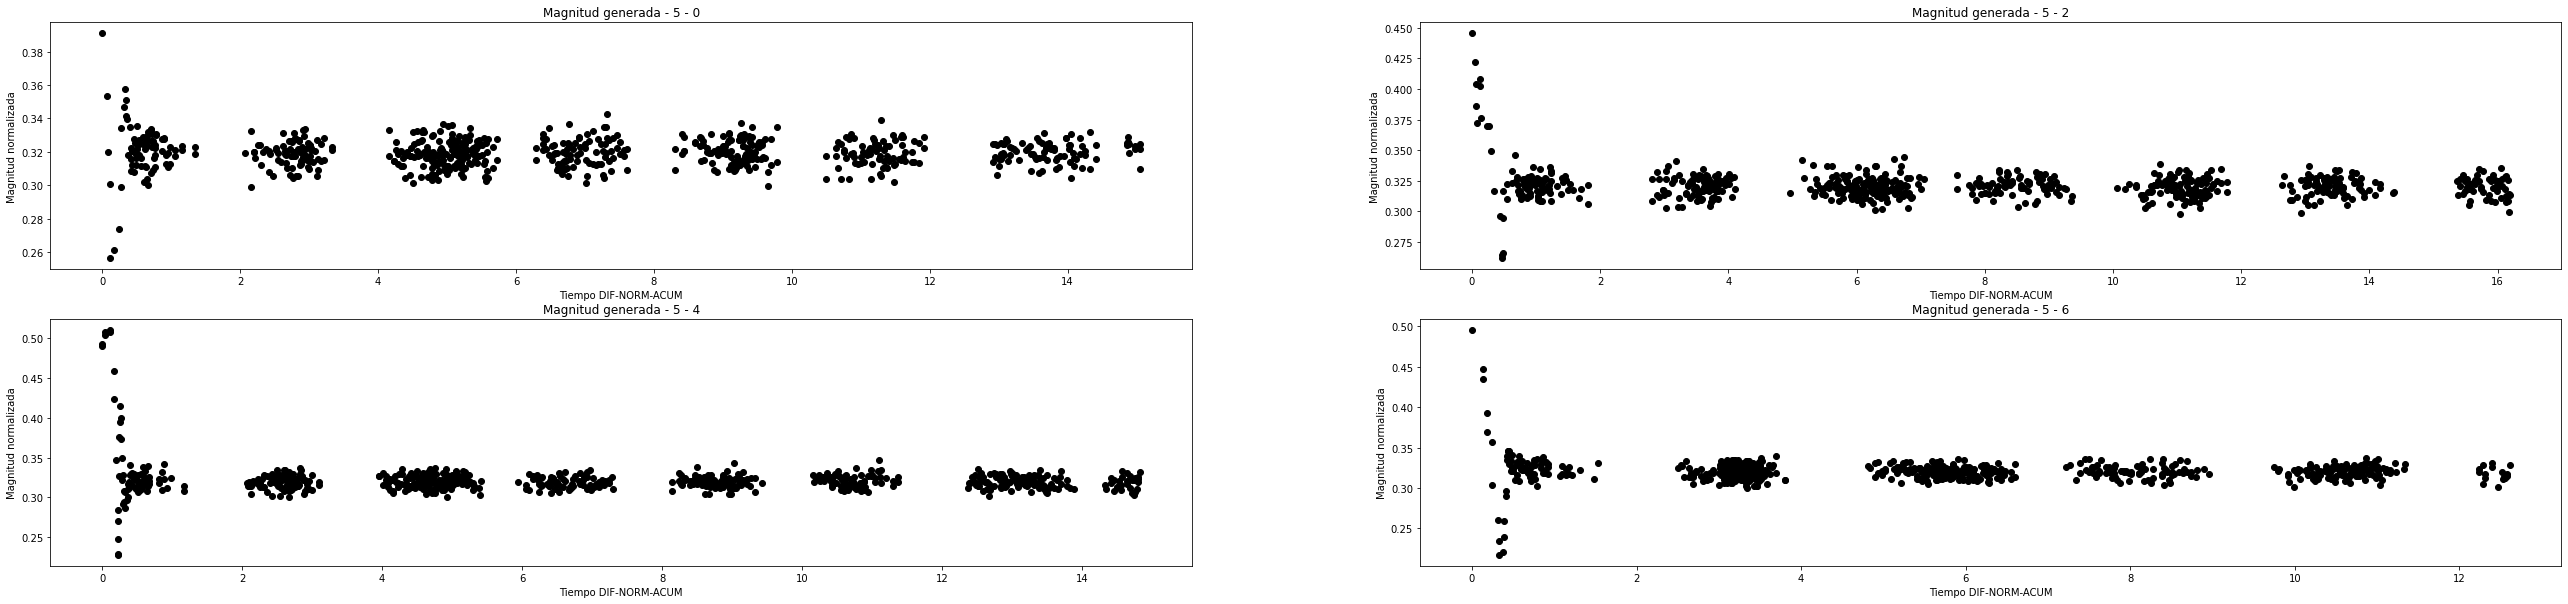

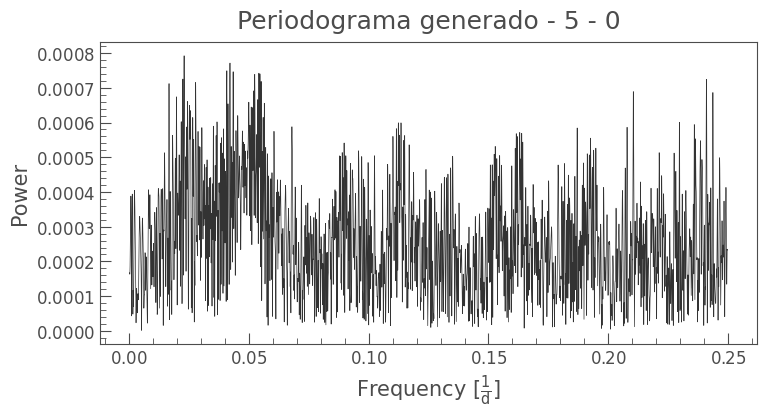

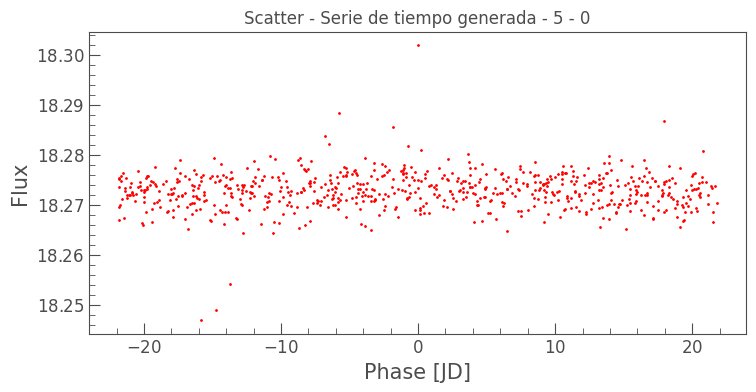

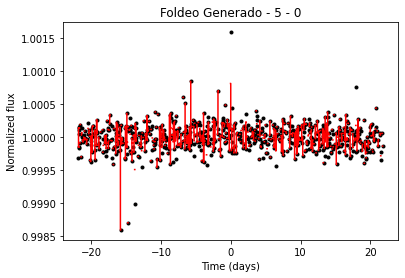

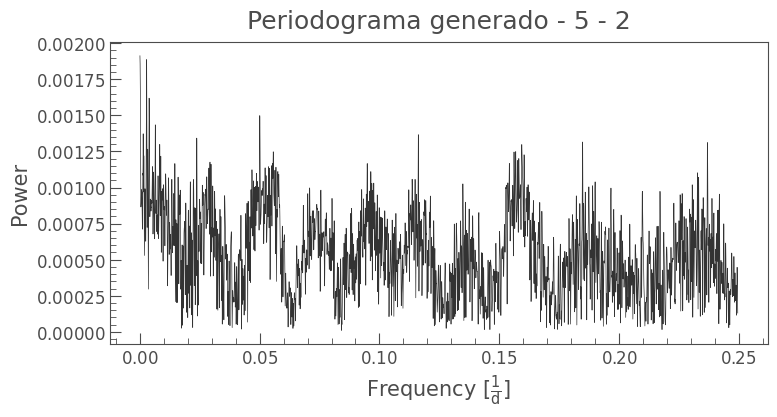

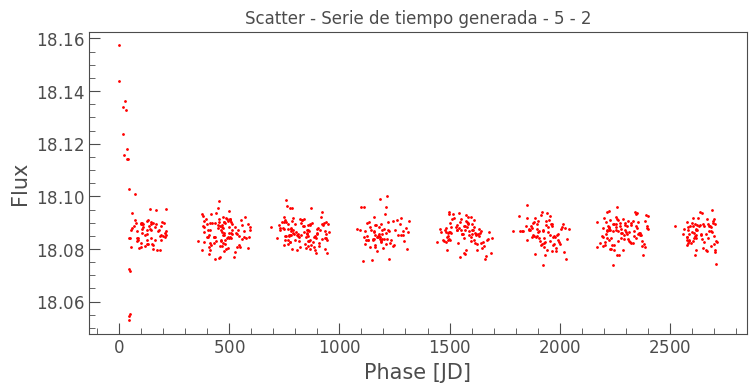

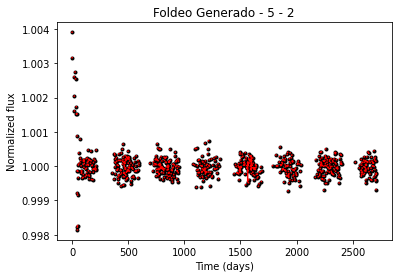

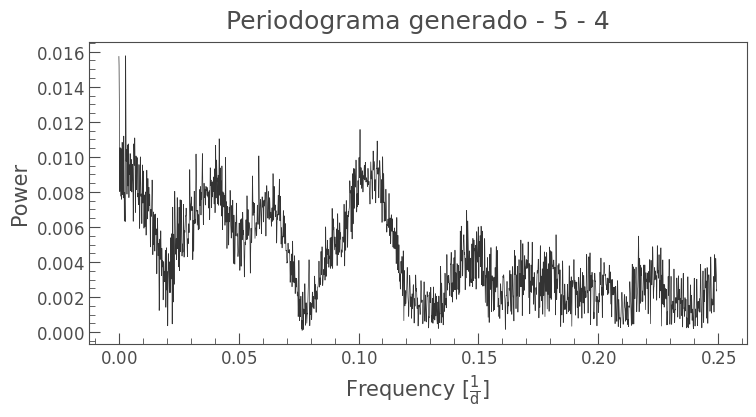

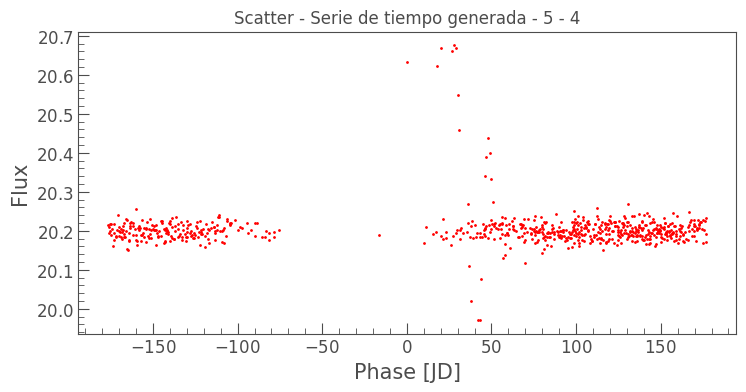

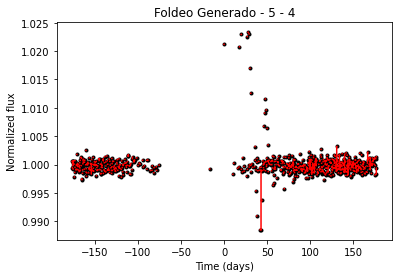

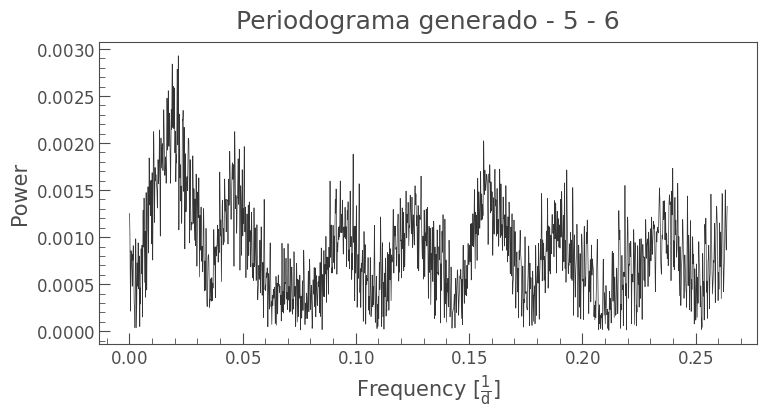

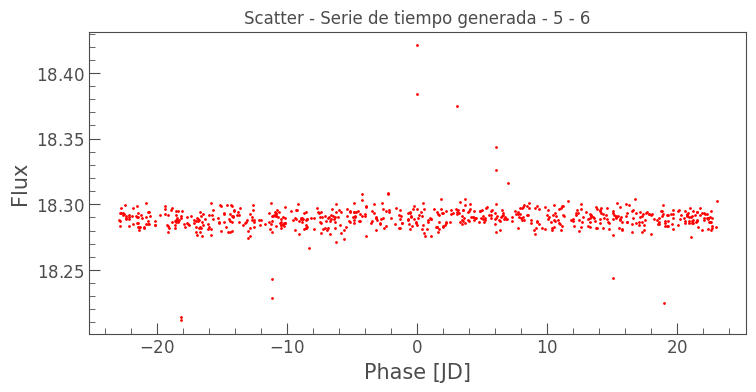

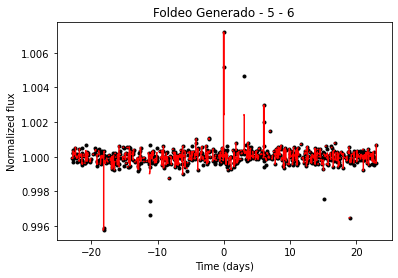

Epoch: 5 - 54 s	 d_loss: 1.3896179795265198 	g_loss: 0.6840100288391113 	Total time: 1 Min. 	ETA: 5 Min. 	RAM usage: 52.84214898313024 %
Epoch: 6 - 11 s	 d_loss: 1.3892521858215332 	g_loss: 0.6863165497779846 	Total time: 1 Min. 	ETA: 0 Min. 	RAM usage: 52.73578703946003 %
Epoch: 7 - 11 s	 d_loss: 1.3887968063354492 	g_loss: 0.6882815957069397 	Total time: 2 Min. 	ETA: 0 Min. 	RAM usage: 52.835801518864365 %
Epoch: 8 - 11 s	 d_loss: 1.3886077404022217 	g_loss: 0.6895677447319031 	Total time: 2 Min. 	ETA: 0 Min. 	RAM usage: 52.67661190561536 %
Epoch: 9 - 11 s	 d_loss: 1.3882602453231812 	g_loss: 0.6905830502510071 	Total time: 2 Min. 	ETA: 0 Min. 	RAM usage: 52.648467488587436 %


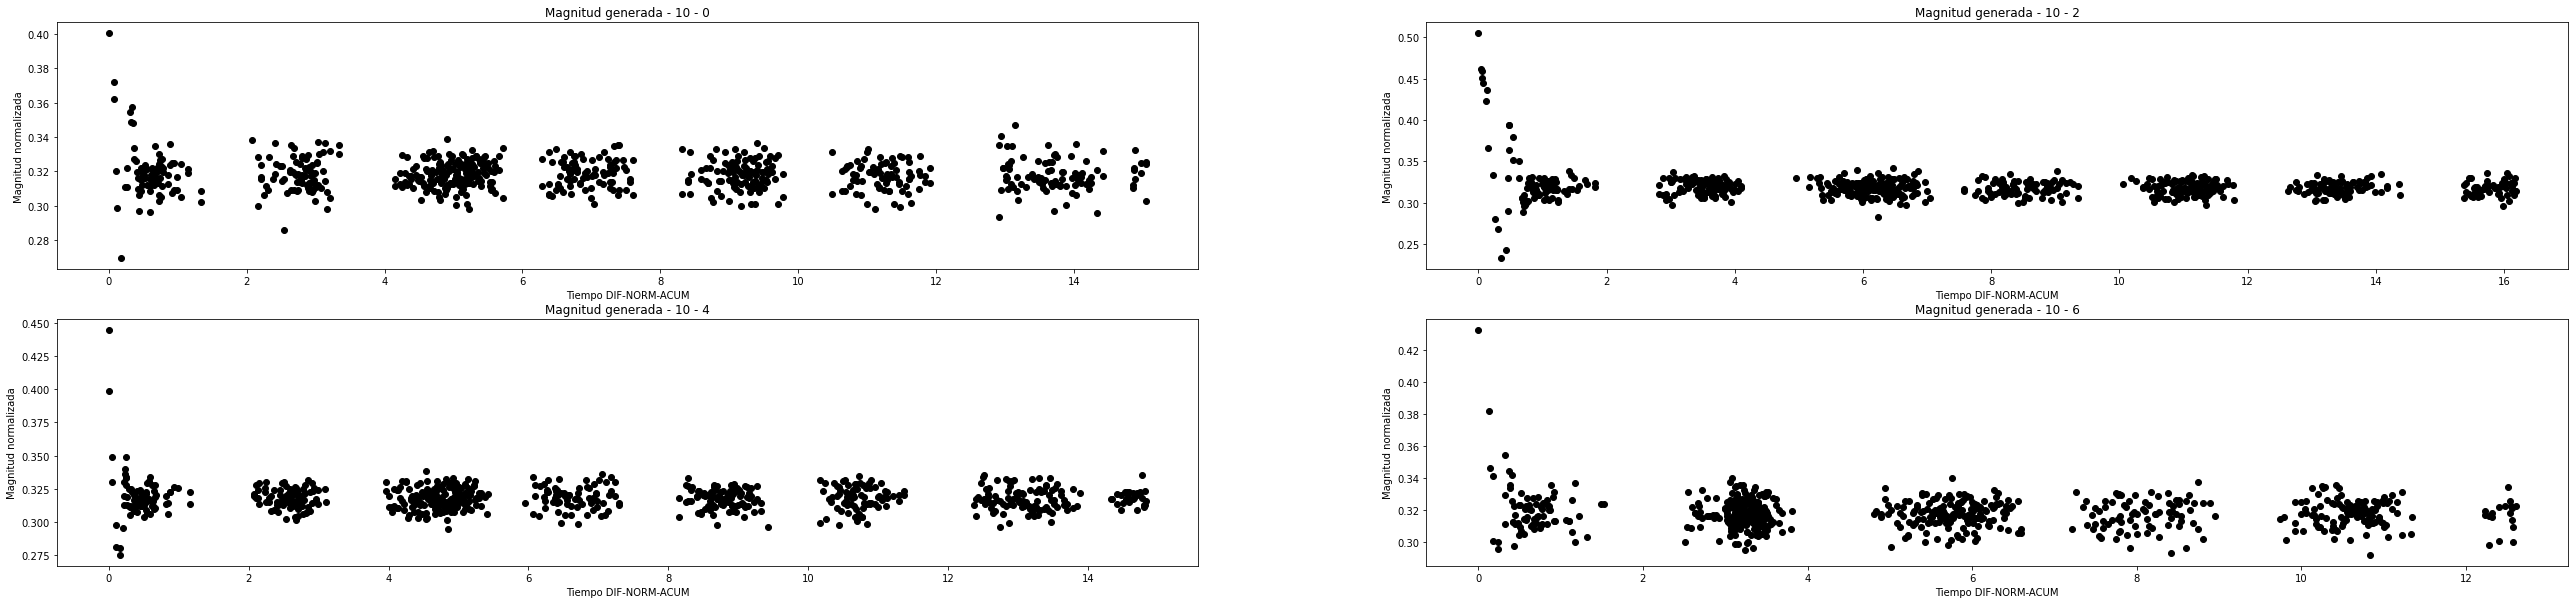

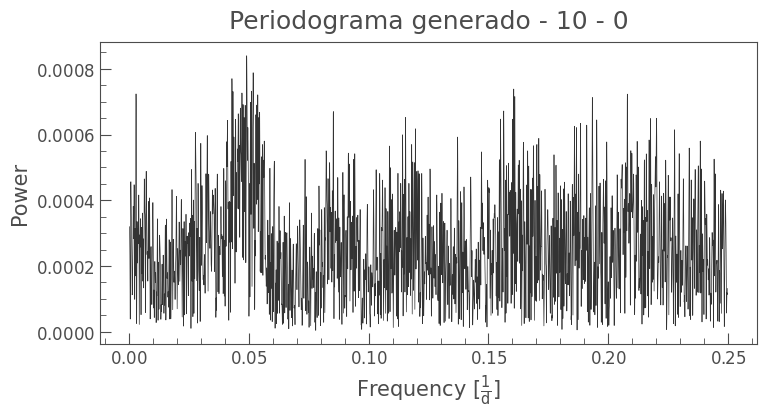

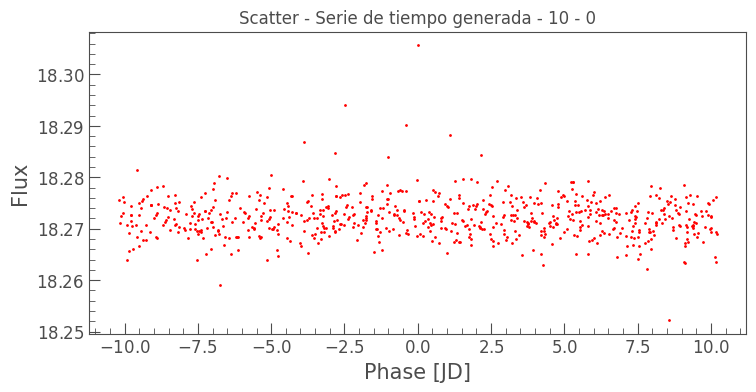

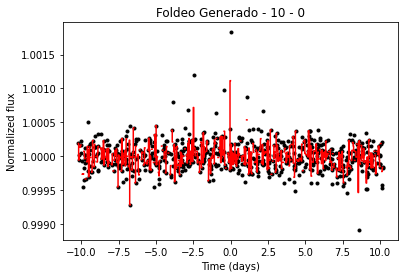

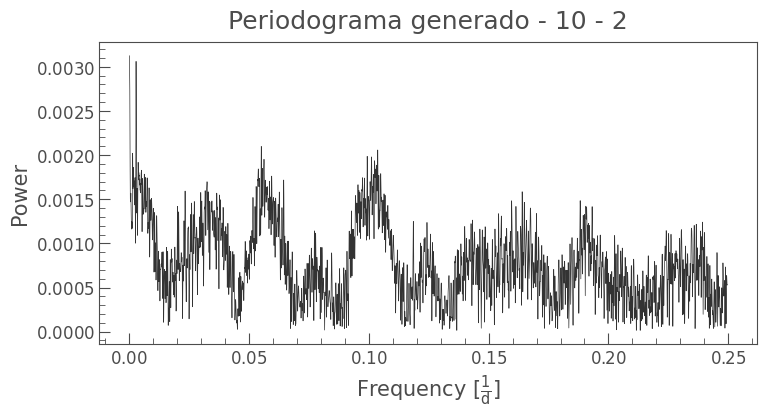

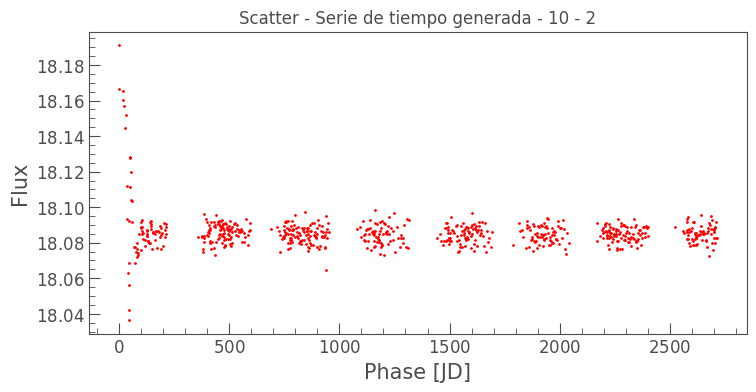

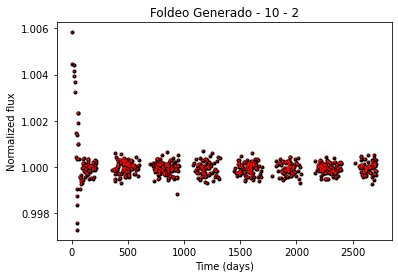

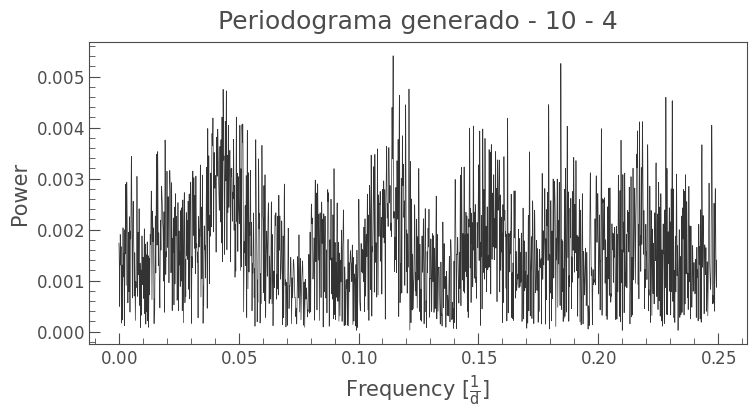

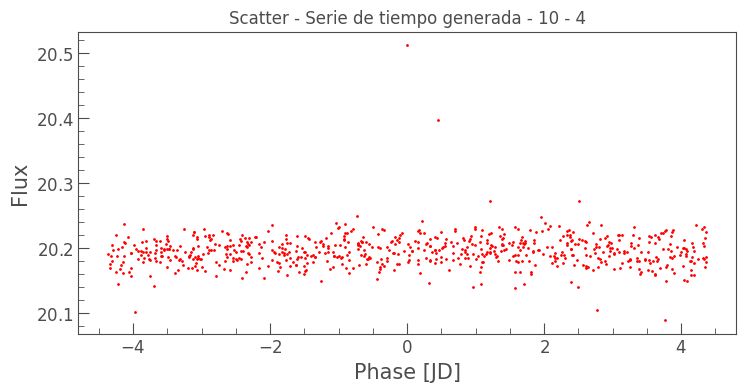

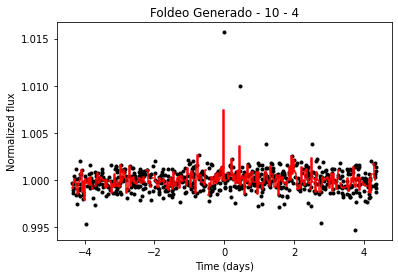

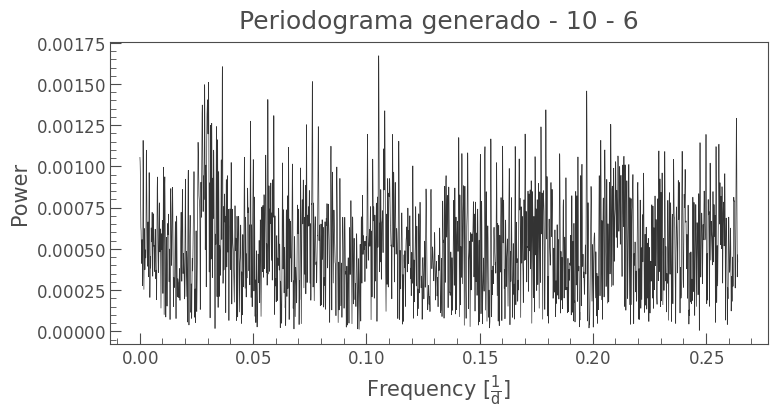

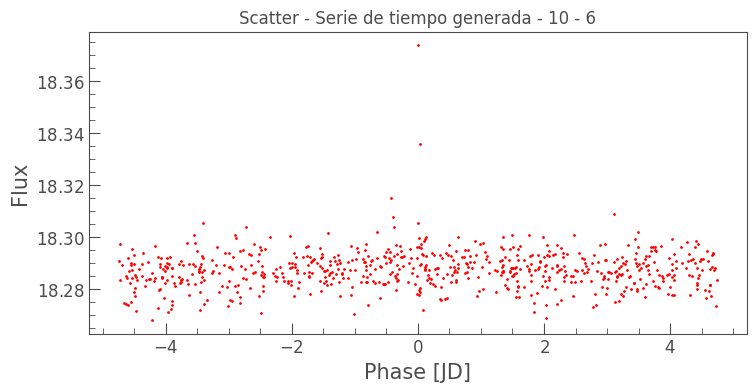

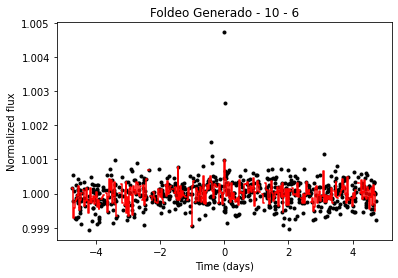

Epoch: 10 - 49 s	 d_loss: 1.388202965259552 	g_loss: 0.6913917660713196 	Total time: 3 Min. 	ETA: 0 Min. 	RAM usage: 52.77244663968236 %


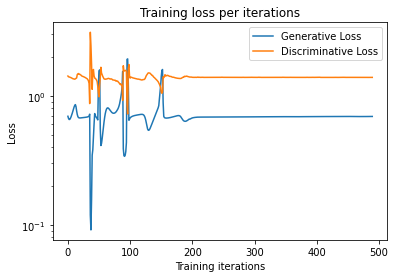

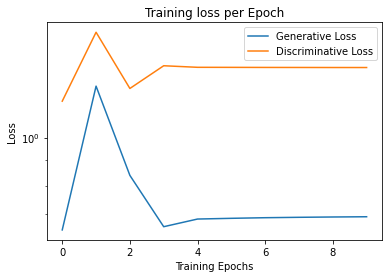

Finished training
Tiempo usado para guardar: 30_01_2022-19_23_29-ED
Models saved in:
.\Archivos_profe\modelos\OGLE-30_01_2022-19_23_29-ED\modelos\discriminador.h5
.\Archivos_profe\modelos\OGLE-30_01_2022-19_23_29-ED\modelos\generador.h5
.\Archivos_profe\modelos\OGLE-30_01_2022-19_23_29-ED\modelos\gan.h5


In [612]:

#(TRAINING AND SAVE MODELS) OR ONLY LOADS MODELS
if training:
    print("Start training")
    train(time_series_original_procesada, diff_samples_tiempo_norm_3dim, g_model, gan_model, epochs, batch_size, sample_interval, cantidad_mediciones, cantidad_series_de_tiempo, ruta_instancia, scaler_mag_normal, samplesBoot_tiempo_sin_norm_3dim)
    print("Finished training")
    #GURADAMOS MODELOS DE DISCRIMINADOR, GENERADOR Y GAN
    print("Tiempo usado para guardar:", tiempo)
    print("Models saved in:")
    guarda_modelo(ruta_instancia, d_model, 'discriminador')
    guarda_modelo(ruta_instancia, g_model, 'generador')
    guarda_modelo(ruta_instancia, gan_model, 'gan')
else:
    print("Loading models from:", path_models)
    #print(path_models)
    #'''
    #WARNING:tensorflow:Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
    #https://github.com/keras-team/autokeras/issues/1162
    #I did some research and the warning states that the state of the optimizer cant be saved, i.e we could not continue the training from the same point it finished. So its not a problem at all.
    #'''
    d_model = keras.models.load_model(path_models + "discriminador.h5")
    g_model = keras.models.load_model(path_models + "generador.h5")
    gan_model = keras.models.load_model(path_models + "gan.h5")
    print("Models loaded")

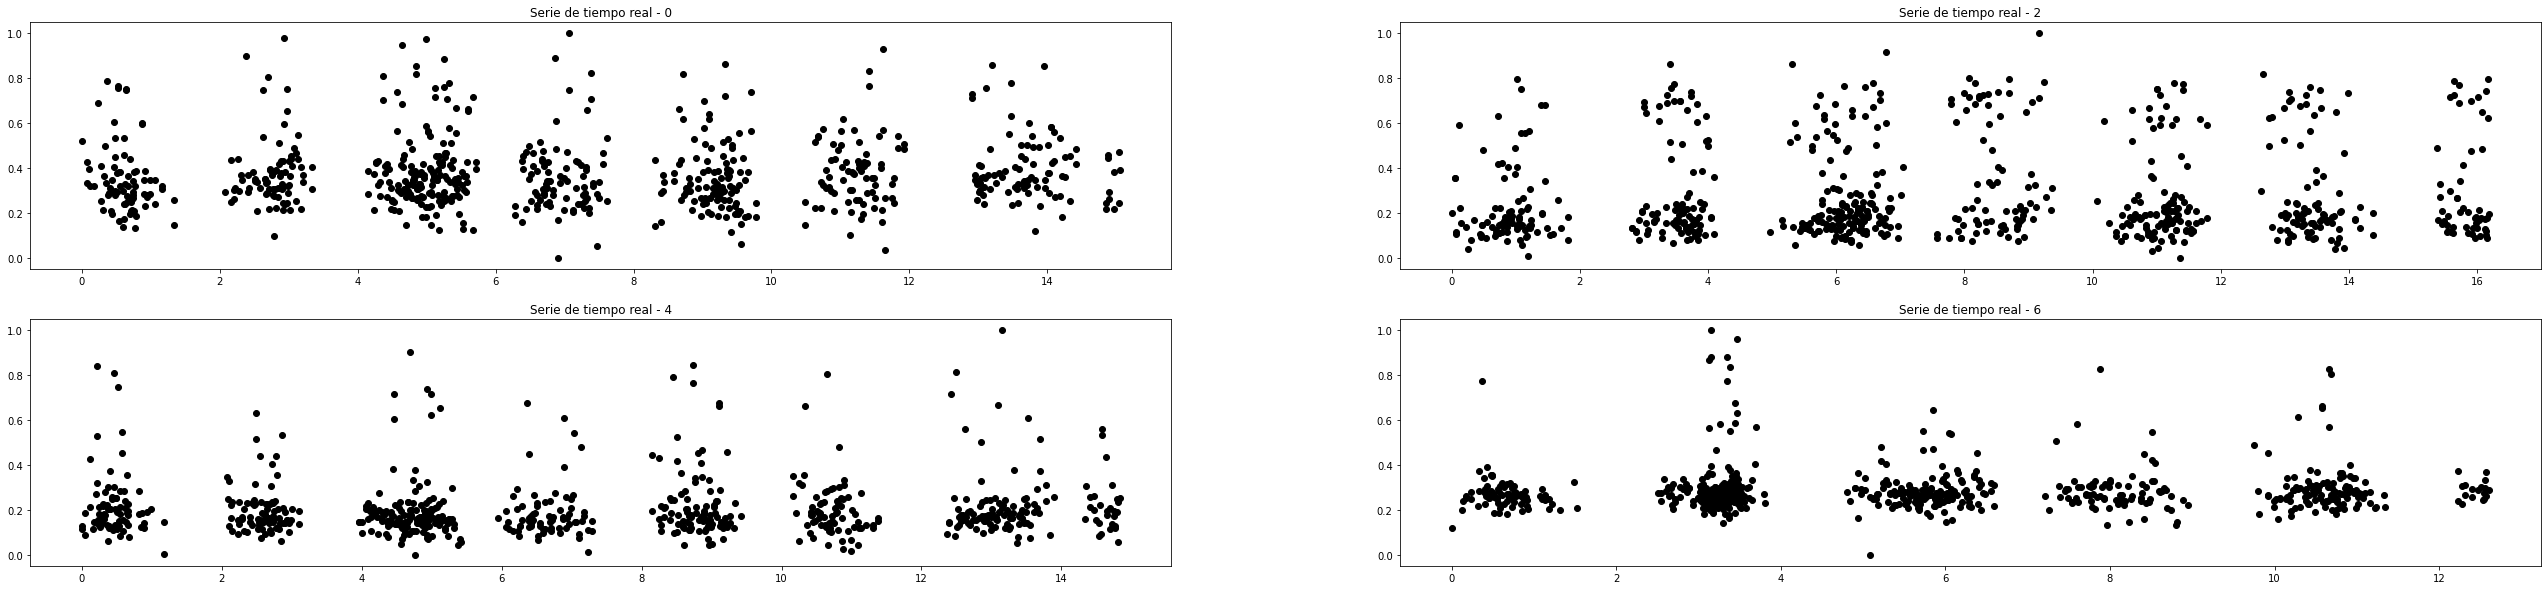

In [613]:
#MOSTRAMOS LA GRAFICA CON LOS DATOS REALES
plot_series_real(samples_magnitud_norm_3dim, diff_samples_tiempo_norm_3dim, ruta_instancia)

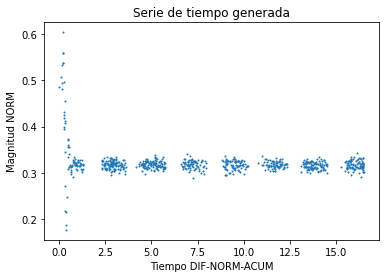

In [614]:
#GENERAMOS NUEVAS MAGNITUDES Y LOS GRAFICAMOS CON TIEMPO BOOTSTRAPEADO...
z = generate_latent_points(cantidad_series_de_tiempo, cantidad_mediciones, 2)
generated_mag = g_model.predict(z)
generated_mag_2dim = generated_mag.reshape((cantidad_series_de_tiempo, cantidad_mediciones))
#Ploteamos
plot_timeseries(diff_samplesBoot_tiempo_norm_3dim, generated_mag_2dim)

In [615]:
#TRABAJAMOS CON EL MODELO DE LSTM PARA CALCULAR EL SCORE DEL MODELO GAN

#Cambiamos la dimension de la magnitud generada
generated_mag_3dim = generated_mag_2dim.reshape((cantidad_series_de_tiempo, cantidad_mediciones,1))
#Calculamos la suma acumulada para el tiempo real
cumsum_diff_samples_tiempo_norm_2dim = np.cumsum(diff_samples_tiempo_norm_3dim[:n_samples_evaluate,:,0], axis=1)
#Calculamos la suma acumulada para el tiempo bootstrapeado
cumsum_diff_samplesBoot_tiempo_norm_2dim = np.cumsum(diff_samplesBoot_tiempo_norm_3dim[:n_samples_evaluate,:,0], axis=1)
#Juntamos el tiempo y magnitud reales ya procesados
time_series_original_procesada = np.vstack(((np.reshape(cumsum_diff_samples_tiempo_norm_2dim, (n_samples_evaluate, cantidad_mediciones, 1))).T, samples_magnitud_norm_3dim[:n_samples_evaluate].T)).T
#Juntamos el tiempo bootstrapeado y la magnitud generada
time_series_boots_procesada = np.vstack(((np.reshape(cumsum_diff_samplesBoot_tiempo_norm_2dim, (n_samples_evaluate, cantidad_mediciones, 1))).T, generated_mag_3dim[:n_samples_evaluate,:,:].T)).T
#Juntamos las series de tiempo reales con las falsas
time_series_original_y_boots = np.concatenate((time_series_original_procesada, time_series_boots_procesada), axis=0)

#Creamos vectores binarios
vector_binario_1 = np.ones((len(time_series_original_procesada),1)) #REAL
vector_binario_0 = np.zeros((len(time_series_boots_procesada), 1)) #FALSO
#Juntamos los vectores binarios
vector_binario = np.concatenate((vector_binario_1, vector_binario_0), axis=0) #Real/Falsa

#INFO
print("cumsum_diff_samples_tiempo_norm_2dim:", cumsum_diff_samples_tiempo_norm_2dim.shape)
print("cumsum_diff_samplesBoot_tiempo_norm_2dim:", cumsum_diff_samplesBoot_tiempo_norm_2dim.shape)
print("time_series_original_procesada:", time_series_original_procesada.shape)
print("time_series_boots_procesada:", time_series_boots_procesada.shape)
print("time_series_original_y_boots:", time_series_original_y_boots.shape)
print("vector_binario:", vector_binario.shape)

#Obtenemos los datos de entrenamiento y evaluacion
x_train, x_test, y_train, y_test = train_test_split(time_series_original_y_boots, vector_binario, test_size=0.2, random_state=5)
#De primer parametro se le pasa la serie de tiempo original concatenada con la falsa. De segundo parametro recibe los vectores binarios 0 y 1.
#x_train son datos de entrenamiento
#x_test son datos para testear
#y_train e y_test son los vectores unitarios (1 y 0) para los "test_size" de datos que se esten utilizando

#INFO
print("x_train:", x_train.shape)
print("y_train:", y_train.shape)
print("x_test:", x_test.shape)
print("y_test", y_test.shape)
print("len_vec_lstm_score:", len_vec_lstm_score)

cumsum_diff_samples_tiempo_norm_2dim: (1000, 700)
cumsum_diff_samplesBoot_tiempo_norm_2dim: (1000, 700)
time_series_original_procesada: (1000, 700, 2)
time_series_boots_procesada: (1000, 700, 2)
time_series_original_y_boots: (2000, 700, 2)
vector_binario: (2000, 1)
x_train: (1600, 700, 2)
y_train: (1600, 1)
x_test: (400, 700, 2)
y_test (400, 1)
len_vec_lstm_score: 2


In [616]:
#(TRAINING AND SAVE MODEL) OR ONLY LOAD MODEL
if training:
    print("Training")
    history = lstm_score_model.fit(x_train, y_train, epochs=epochs_score, validation_data=(x_test, y_test))
    print("Training finished")
    print("Tiempo usado para guardar:", tiempo)
    print("Saving model")
    guarda_modelo(ruta_instancia, lstm_score_model, 'lstm_score')
    print("Model saved")
else:
    print("Loading models")
    lstm_score_model = keras.models.load_model(path_models + "lstm_score.h5")
    print("Models loaded")

Training
Epoch 1/10
50/50 [==============================] - 3s 35ms/step - loss: 0.6958 - accuracy: 0.5153 - val_loss: 0.6900 - val_accuracy: 0.5363
Epoch 2/10
50/50 [==============================] - 1s 29ms/step - loss: 0.6924 - accuracy: 0.5204 - val_loss: 0.6958 - val_accuracy: 0.4729
Epoch 3/10
50/50 [==============================] - 1s 29ms/step - loss: 0.6930 - accuracy: 0.5105 - val_loss: 0.6891 - val_accuracy: 0.5404
Epoch 4/10
50/50 [==============================] - 1s 29ms/step - loss: 0.6926 - accuracy: 0.5229 - val_loss: 0.6926 - val_accuracy: 0.5214
Epoch 5/10
50/50 [==============================] - 1s 29ms/step - loss: 0.6921 - accuracy: 0.5217 - val_loss: 0.7042 - val_accuracy: 0.4726
Epoch 6/10
50/50 [==============================] - 1s 29ms/step - loss: 0.6944 - accuracy: 0.5083 - val_loss: 0.7025 - val_accuracy: 0.4730
Epoch 7/10
50/50 [==============================] - 1s 29ms/step - loss: 0.6876 - accuracy: 0.5385 - val_loss: 0.7537 - val_accuracy: 0.5419
Epoc

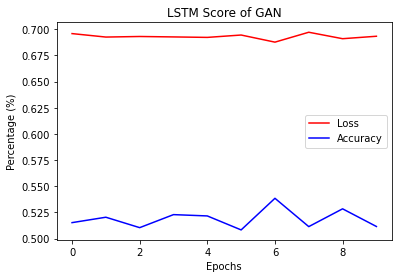

[0.6913127899169922, 0.5179356932640076]
Test Loss: 0.6913127899169922
Test Accuracy: 0.5179356932640076
[0.6895245313644409, 0.5166652202606201]
Training Loss: 0.6895245313644409
Training Accuracy: 0.5166652202606201


In [617]:
#PLOTEAMOS EL ACCURACY DE LA LSTM
if training:
    plt.plot(history.history['loss'], c='r', label='Loss')
    plt.plot(history.history['accuracy'], c='b', label='Accuracy')
    #plt.plot(xlabel='Epochs')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Percentage (%)')
    plt.title('LSTM Score of GAN')
    plt.savefig(ruta_instancia + '\\' + 'LSTM-Score.pdf', dpi=1200, format='pdf')
    plt.show()
    #plt.clf()
    #plt.pause(0.0001)
    #Obtenemos el score del x_text e y_test
    resultados_test = lstm_score_model.evaluate(x_test, y_test, verbose=0)
    resultados_training = lstm_score_model.evaluate(x_train, y_train, verbose=0)

    print(resultados_test) #[{loss},|metrics|]
    print("Test Loss:", resultados_test[0])
    print("Test Accuracy:", resultados_test[1])
    lista_resultados.append(resultados_test[1])
    #lista_resultados_test_accuracy.append(resultados_test[1])

    print(resultados_training) #[{loss},|metrics|]
    print("Training Loss:", resultados_training[0])
    print("Training Accuracy:", resultados_training[1])
    #lista_resultados_training_accuracy.append(resultados_training[1])

In [618]:
#ZONA DE FOLDEO
#PRIMERO FOLDEAMOS LAS SERIES DE TIEMPO GENERADAS Y LUEGO LAS REALES

In [619]:
#PROCESAMOS LOS DATOS GENERADOS PARA FOLDEARLOS

#Desnormalizamos la magnitud generada
generated_mag_sin_norm_2dim = scaler_mag_normal.inverse_transform(generated_mag_2dim.T).T
#Cambiamos la dimension
generated_mag_sin_norm_3dim = generated_mag_sin_norm_2dim.reshape((cantidad_series_de_tiempo, cantidad_mediciones, 1))
#Juntamos el tiempo boostrapeado con la magnitud generada
time_series_generada_3dim = np.vstack((samplesBoot_tiempo_sin_norm_3dim.T, generated_mag_sin_norm_3dim.T)).T

In [620]:
#Nombre de columnas de la instnacia del archivo de OGLE
nombre_columnas = ['time', 'magnitud', 'error'] 
#Rellenamos la columna 'error' de la libreria para foldear (no podemos foldear sin esta columna).
test_0 = np.zeros((cantidad_series_de_tiempo, cantidad_mediciones, 1))
#Concatenamos la columna de 0's
time_series_generada_3dim = np.vstack((time_series_generada_3dim.T, test_0.T)).T
#Pasamos la serie de tiempo al df y utilizamos solo 1 serie de tiempo para ver el foldeo
df_generado = pd.DataFrame(time_series_generada_3dim[20,:,:], columns=nombre_columnas)
if 'WISE' not in ruta_instancia:
    #Sumamos un escalar al tiempo para un foldeo correcto
    df_generado['time'] = df_generado['time'] + 2450000
df_generado

,time,magnitud,error
0,2452086.89212,19.411669,0.0
1,2452103.89894,19.388784,0.0
2,2452105.92907,19.369013,0.0
3,2452106.89468,19.360315,0.0
4,2452112.84706,19.37188,0.0
...,...,...,...
695,2454769.64307,19.27924,0.0
696,2454771.55412,19.266798,0.0
697,2454772.59926,19.269115,0.0
698,2454772.67595,19.261576,0.0


In [621]:
df_generado_dtype_float = df_generado.astype(float) #Creamos una copia del {df_generado} como flotante.
#print(df_generado_dtype_float)

if training:
    df_generado_dtype_float.to_csv(path_or_buf=ruta_instancia + '\\' + 'SerieTiempo-Generada.csv', sep=' ', index=False)

#list(Time.FORMATS)

#Convertimos el df a un LightCurve
lc_generado = lk.LightCurve(time=df_generado_dtype_float['time'], flux=df_generado_dtype_float['magnitud'], flux_err=df_generado_dtype_float['error'])
lc_generado

time,flux,flux_err
,,
Time,float64,float64
2452086.89212,19.41166877746582,0.0
2452103.89894,19.388784408569336,0.0
2452105.92907,19.3690128326416,0.0
2452106.89468,19.360315322875977,0.0
2452112.84706,19.37187957763672,0.0
2452116.87482,19.372873306274414,0.0
2452123.82175,19.36043930053711,0.0
2452124.84219,19.368206024169922,0.0


In [622]:
#Calculamos el periodograma usando el metodo de'lombscargle'
pg_generado = lc_generado.to_periodogram(method='lombscargle', oversample_factor=10)

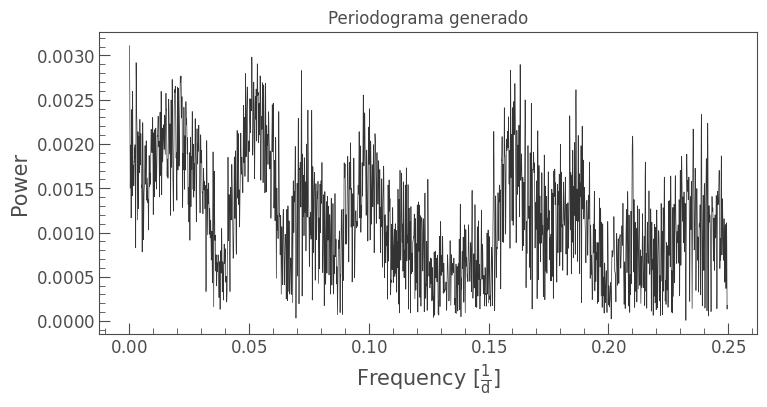

In [623]:
#PLOTEAMOS EL PERIODOGRAMA
periodograma = pg_generado.plot()
periodograma.set_title("Periodograma generado")
if training:
    periodograma.figure.savefig(ruta_instancia + '\\' + 'Periodograma-Generado-Post-Training.pdf', dpi=1200, format='pdf')

In [624]:
#INFO
pg_generado.show_properties()
print("Frequency at max power:", pg_generado.frequency_at_max_power)
print("Periodo:", pg_generado.period_at_max_power)
lista_resultados.append(pg_generado.period_at_max_power)

lightkurve.Periodogram properties:
      Attribute                   Description            Units
---------------------- --------------------------------- -----
                nterms                                 1      
          default_view                         frequency      
             ls_method                              fast      
frequency_at_max_power                               0.0 1 / d
             max_power                            0.0031      
               nyquist                            0.2497 1 / d
   period_at_max_power                         26866.713     d
             frequency                     array (6707,) 1 / d
                period                     array (6707,)     d
                 power                     array (6707,)      
                 label                <class 'NoneType'>      
                  meta <class 'collections.OrderedDict'>      
              targetid                <class 'NoneType'>      
Frequency at max pow

       time               flux        flux_err time_original
                                                            
------------------ ------------------ -------- -------------
               0.0  19.41166877746582      0.0 2452086.89212
17.006820000241753 19.388784408569336      0.0 2452103.89894
  19.0369500000968   19.3690128326416      0.0 2452105.92907
 20.00255999993395 19.360315322875977      0.0 2452106.89468
 25.95494000008261  19.37187957763672      0.0 2452112.84706
  29.9827000000521 19.372873306274414      0.0 2452116.87482
 36.92963000014424  19.36043930053711      0.0 2452123.82175
 37.95007000025224 19.368206024169922      0.0 2452124.84219
41.937129999975916 19.326723098754883      0.0 2452128.82925
 42.96910999994587 19.268264770507812      0.0 2452129.86123
               ...                ...      ...           ...
2670.7491600001244 19.259626388549805      0.0 2454757.64128
2672.7617500000642  19.27277374267578      0.0 2454759.65387
2674.7320400001495  19.2

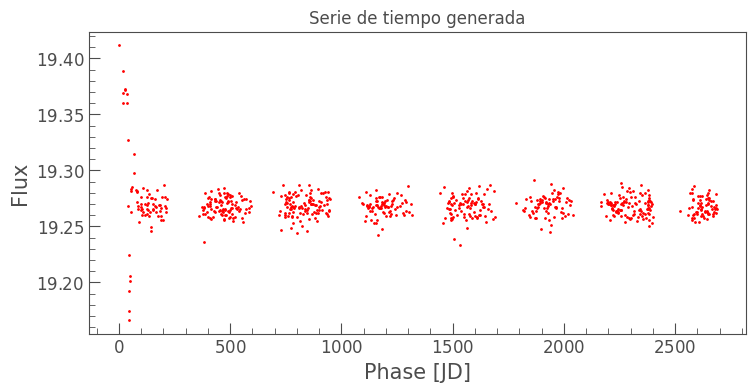

In [625]:
#FOLDEO
#Todavia no puedo foldear con la fase normalizada en la misma funcion ya que elimina la unidad de 'JD' y no he logrado solucionarlo. Usar dias como unidad tampoco funciona.
lc_generado_foldeado = lc_generado.fold(pg_generado.period_at_max_power, normalize_phase=False)
print(lc_generado_foldeado)
lc_scatter = lc_generado_foldeado.scatter(color='red')
lc_scatter.set_title("Serie de tiempo generada")
if training:
    lc_scatter.figure.savefig(ruta_instancia + '\\' + 'SerieTiempo-Generada-Scatter-Post-Training.pdf', dpi=1200, format='pdf')

In [626]:
#Normalizamos las magnitudes
lc_generado_normalizado = lc_generado.normalize()
lc_generado_normalizado

time,flux,flux_err
,,
Time,float64,float64
2452086.89212,1.0074486802590126,0.0
2452103.89894,1.0062610014711855,0.0
2452105.92907,1.0052348739237094,0.0
2452106.89468,1.0047834807521399,0.0
2452112.84706,1.0053836554888123,0.0
2452116.87482,1.0054352291384587,0.0
2452123.82175,1.0047899150846293,0.0
2452124.84219,1.0051930012676624,0.0


In [627]:
#Intento de samplear y normalizar el foldeo
median_generada = st.median(lc_generado_foldeado['flux'])
mean_generada = st.mean(lc_generado_foldeado['flux'].value)
stddev_generada = st.stdev(lc_generado_foldeado['flux'].value)

lc_generado_foldeado['flux_norm'] = lc_generado_foldeado['flux'] / mean_generada

In [628]:
lc_generado_foldeado_binned = lc_generado_foldeado.bin(0.03)
lc_generado_foldeado_binned

time,flux,flux_err,time_bin_start,time_bin_size,flux_norm
,,,,d,
TimeDelta,float64,float64,TimeDelta,float64,float64
0.015,19.41166877746582,0.0,0.0,0.03,1.0074118310285725
0.045,nan,nan,0.03,0.03,nan
0.075,nan,nan,0.06,0.03,nan
0.105,nan,nan,0.09,0.03,nan
0.135,nan,nan,0.12,0.03,nan
0.16499999999999998,nan,nan,0.15,0.03,nan
0.195,nan,nan,0.18,0.03,nan
0.22499999999999998,nan,nan,0.21,0.03,nan


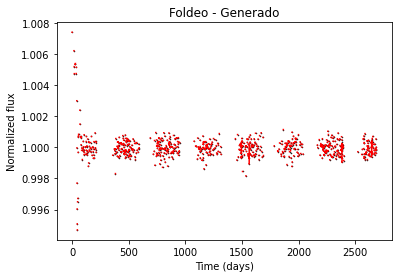

In [629]:
plt.clf()
plt.plot(lc_generado_foldeado.time.jd, lc_generado_foldeado['flux_norm'], 'k.', markersize=1)
plt.plot(lc_generado_foldeado_binned.time_bin_start.jd, lc_generado_foldeado_binned['flux_norm'], 'r-', drawstyle='steps-mid')
plt.xlabel('Time (days)')
plt.ylabel('Normalized flux')
plt.title("Foldeo - Generado")
if training:
    plt.savefig(ruta_instancia + '\\' + 'Foldeo-Generado-Post-Training.pdf', dpi=1200, format='pdf')
plt.show()
#plt.clf()
#plt.pause(0.0001)

In [630]:
#PROCESAMOS LOS DATOS REALES PARA FOLDEARLOS

In [631]:
#Seleccionamos una serie de tiempo real al azar para foldear
x = random.randint(0,len(lista_nombre_instancias)-1)
nombre_serie_tiempo = lista_nombre_instancias[x]

In [632]:
#Ruta de la serie de tiempo a foldear
path_photometry = path_datos + '\\' + nombre_serie_tiempo + extension_series_de_tiempo
#print("Cargando archivo:", path_photometry)

#Cargamos la serie de tiempo
if 'OGLE' in path_index: 
    df_real = pd.read_csv(path_photometry, sep=' ', names=['time', 'magnitud', 'error', '1', '2', '3', '4'])
elif 'GAIA' in path_index:
    df_real = pd.read_csv(path_photometry, sep=',', names=['time', 'magnitud', 'error', '1', '2', '3', '4'], skiprows=1)
elif 'WISE' in path_index:
    df_real = pd.read_csv(path_photometry, sep=',', names=['time', 'magnitud', 'error', '1', '2', '3', '4'], skiprows=1)
else:
    print("ERROR #### NO SE PUDO CARGAR LA SERIE DE TIEMPO ####")

#Como hay datos que vienen con muchas columnas, eliminamos las columnas extras que tengan
while len(df_real.columns) > 3:
    df_real.drop(df_real.columns[len(df_real.columns)-1], axis=1, inplace=True)

#Modificamos el tiempo para que podamos foldear la serie de tiempo
if 'WISE' not in ruta_instancia:
    df_real['time'] = df_real['time'] + 2450000
#df_real = df_real.loc[:1299]
df_real

,time,magnitud,error
0,2.452091e+06,17.348,0.020
1,2.452106e+06,17.326,0.016
2,2.452107e+06,17.356,0.019
3,2.452114e+06,17.349,0.017
4,2.452117e+06,17.329,0.015
...,...,...,...
702,2.454849e+06,17.344,0.015
703,2.454851e+06,17.485,0.020
704,2.454855e+06,17.366,0.018
705,2.454863e+06,17.640,0.017


In [633]:
lc_real = lk.LightCurve(time=df_real['time'], flux=df_real['magnitud'], flux_err=df_real['error'])
lc_real

time,flux,flux_err
,,
Time,float64,float64
2452090.90645,17.348,0.02
2452105.90431,17.326,0.016
2452106.869,17.356,0.019
2452113.84931,17.349,0.017
2452116.85251,17.329,0.015
2452122.7917,17.387,0.027
2452123.7992599998,17.371,0.017
2452124.81635,17.584,0.041


In [634]:
pg_real = lc_real.to_periodogram(method='lombscargle', oversample_factor=10) #Calculamos el periodograma usando el metodo de'lombscargle'

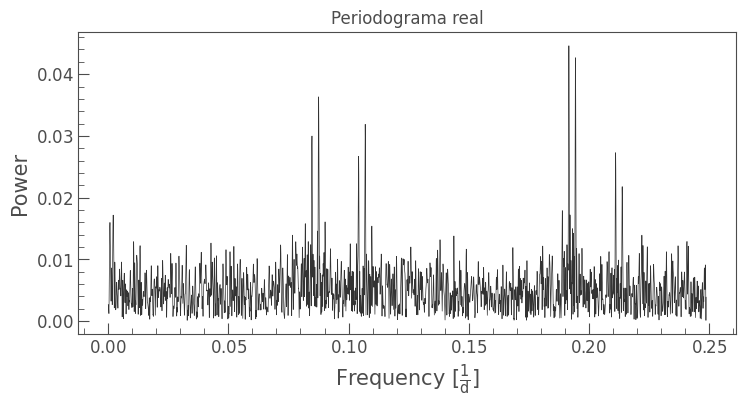

In [635]:
periodograma = pg_real.plot()
periodograma.set_title("Periodograma real")
if training:
    periodograma.figure.savefig(ruta_instancia + '\\' + 'Periodograma-Real.pdf', dpi=1200, format='pdf')

In [636]:
pg_real.show_properties()
print("Frequency at max power:", pg_real.frequency_at_max_power)
print("Periodo:", pg_real.period_at_max_power)
lista_resultados.append(pg_real.period_at_max_power)

lightkurve.Periodogram properties:
      Attribute                   Description            Units
---------------------- --------------------------------- -----
                nterms                                 1      
          default_view                         frequency      
             ls_method                              fast      
frequency_at_max_power                            0.1917 1 / d
             max_power                            0.0446      
               nyquist                            0.2488 1 / d
   period_at_max_power                            5.2174     d
             frequency                     array (6905,) 1 / d
                period                     array (6905,)     d
                 power                     array (6905,)      
                 label                <class 'NoneType'>      
                  meta <class 'collections.OrderedDict'>      
              targetid                <class 'NoneType'>      
Frequency at max pow

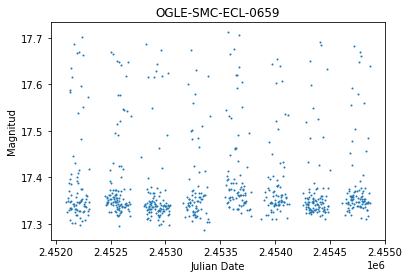

In [637]:
df_real = df_real[(df_real.T != 0).any()]
#print(df_real['time'])
#print(df_real['magnitud'])
plt.clf()
plt.plot(df_real['time'], df_real['magnitud'], 'o', markersize=1)
plt.xlabel('Julian Date')
plt.ylabel('Magnitud')
plt.title(nombre_serie_tiempo)
if training:
    plt.savefig(ruta_instancia + '\\' + 'SerieTiempo-Original-' + nombre_serie_tiempo + '.pdf')
plt.show()
#plt.clf()
#plt.pause(0.0001)

Text(0.5, 1.0, 'Serie de tiempo real - Binned')

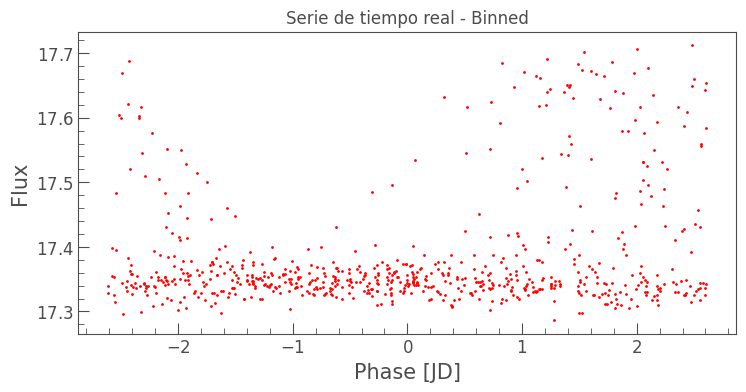

In [638]:
#Todavia no puedo foldear con la fase normalizada en la misma funcion ya que elimina la unidad de 'JD' y no he logrado solucionarlo. Usar dias como unidad tampoco funciona.
lc_real_foldeada = lc_real.fold(pg_real.period_at_max_power, normalize_phase=False)
#print(lc_real_foldeada)
lc_scatter = lc_real_foldeada.scatter(color='red')
lc_scatter.set_title("Serie de tiempo real - Binned")
#lc_scatter.figure.savefig(ruta_instancia + '\\' + 'Binned-SerieTiempo-Original-LightCurve-Scatter-' + nombre_serie_tiempo + '.png')

In [639]:
lc_real_normalizada = lc_real.normalize()
lc_real_normalizada

time,flux,flux_err
,,
Time,float64,float64
2452090.90645,0.9999423597901895,0.0011528041962072743
2452105.90431,0.9986742751743617,0.0009222433569658193
2452106.869,1.0004034814686726,0.0010951639863969105
2452113.84931,1.0,0.000979883566776183
2452116.85251,0.9988471958037928,0.0008646031471554556
2452122.7917,1.0021903279727937,0.0015562856648798202
2452123.7992599998,1.001268084615828,0.000979883566776183
2452124.81635,1.0135454493054354,0.0023632486022249124


In [640]:
median_real = st.median(lc_real_foldeada['flux'])
mean_real = st.mean(lc_real_foldeada['flux'].value)
stddev_real = st.stdev(lc_real_foldeada['flux'].value)

lc_real_foldeada['flux_norm'] = lc_real_foldeada['flux'] / mean_real

In [641]:
lc_real_foldeada_binned = lc_real_foldeada.bin(0.03)
lc_real_foldeada_binned

time,flux,flux_err,time_bin_start,time_bin_size,flux_norm
,,,,d,
TimeDelta,float64,float64,TimeDelta,float64,float64
-2.5932593236062393,17.3345,0.011926860441876564,-2.6082593236062395,0.03,0.9971258623409656
-2.5632593236062395,17.3498,0.006913754406977442,-2.5782593236062397,0.03,0.9980059584322181
-2.5332593236062397,17.494333333333334,0.009098229375970787,-2.5482593236062394,0.03,1.0063198944925034
-2.5032593236062395,17.634500000000003,0.016007810593582122,-2.5182593236062396,0.03,1.0143826484439562
-2.4732593236062397,17.32,0.013435028842544402,-2.48825932360624,0.03,0.9962917843459878
-2.4432593236062394,17.451166666666666,0.0072724747430904756,-2.4582593236062396,0.03,1.0038368347143507
-2.4132593236062396,17.376857142857144,0.008029283140797941,-2.4282593236062393,0.03,0.9995623561883639
-2.3832593236062394,17.341,0.012020815280171309,-2.3982593236062395,0.03,0.9974997593731971


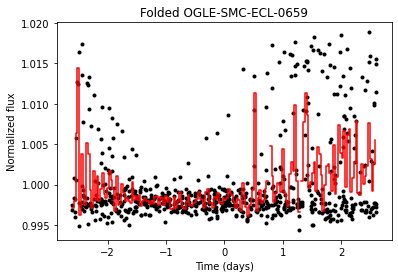

In [642]:
plt.clf()
plt.plot(lc_real_foldeada.time.jd, lc_real_foldeada['flux_norm'], 'k.')
plt.plot(lc_real_foldeada_binned.time_bin_start.jd, lc_real_foldeada_binned['flux_norm'], 'r-', drawstyle='steps-post')
plt.xlabel('Time (days)')
plt.ylabel('Normalized flux')
plt.title('Folded ' + nombre_serie_tiempo)
if training:
    plt.savefig(ruta_instancia + '\\' + 'Foldeo-Original-' + nombre_serie_tiempo + '.pdf')
plt.show()
#plt.clf()
#plt.pause(0.0001)

In [643]:
#Guardamos algunos resultados del trabajo
if training:
    guarda_resultados(config, path_models_root, tiempo, lista_resultados)

[0.5179356932640076, <Quantity 26866.713 d>, <Quantity 5.21737897 d>]
Parametros guardados en: .\Archivos_profe\modelos\OGLE-30_01_2022-19_23_29-ED\parametros.init
